<a href="https://colab.research.google.com/github/arpanbiswas52/iMFBO_Ising/blob/main/iBO_notebook_numerical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **non-interractive and interractive Multi-fidelity Bayesian optimization**
Jan, 2024

-- Notebook prepared by **Arpan Biswas**

-- Structured GP is developed by **Maxim Ziatdinov** in GPax Python library, expanded to multi-fidelity structred GP by **Arpan Biswas**




In [ ]:
!pip install -q git+https://github.com/ziatdinovmax/gpax.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.3/360.3 kB 18.3 MB/s eta 0:00:00


In [ ]:
import gpax
import numpy as np
import matplotlib.pyplot as plt

gpax.utils.enable_x64()  # enable double precision

from typing import Union, Dict, Callable

import math

import jax.numpy as jnp
from jax import jit
from gpax.kernels import RBFKernel

import jax
import numpyro

# Test Problem 1

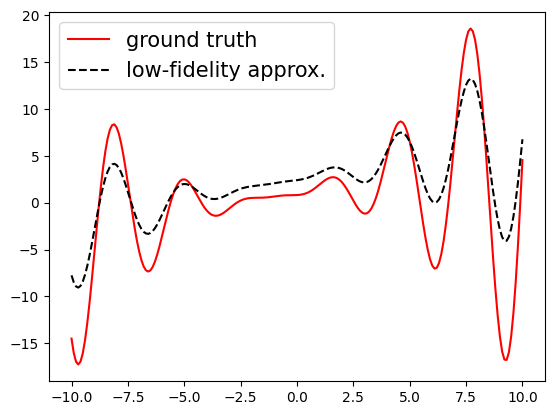

In [ ]:
def objective(x):
    # a modification of https://www.sfu.ca/~ssurjano/forretal08.html
    y = -((x + 1) ** 2) * np.sin(2 * x + 2) / 5 + 1 + x / 3
    return y


def approx_objective(x):
    return 0.5 * objective(x) + x / 4 + 2


def evaluate_all_functions(x_full):
    y = []
    for x in x_full:
        if np.isclose(x[-1], np.ones(1)):
            y.append(objective(x[:-1]))
        else:
            y.append(approx_objective(x[:-1]))

    return np.asarray(y)


lb = -10
ub = 10

bounds = np.array((lb, ub), dtype=float)
fidelities = np.array((0.95, 1.0))

xs = np.linspace(lb, ub, 201)
xs_norm = (xs-lb)/(ub-lb)

ys = objective(xs)
approx_ys = approx_objective(xs)


plt.plot(xs, ys, label="ground truth", c="r")
plt.plot(xs, approx_ys, "k--", label="low-fidelity approx.")

plt.legend(fontsize=15);

In [ ]:

def fidelity_kernel_prior() -> Dict[str, jnp.ndarray]:
    length = numpyro.sample("k_length", numpyro.distributions.HalfNormal(1))
    scale = numpyro.sample("k_scale", numpyro.distributions.HalfNormal(3))
    delta = numpyro.sample("delta", numpyro.distributions.HalfNormal(1))
    return {"k_length": length, "k_scale": scale, "delta": delta}

def fidelity_kernel_prior2() -> Dict[str, jnp.ndarray]:
    length = numpyro.sample("k_length", numpyro.distributions.Uniform(0.10,3))
    scale = numpyro.sample("k_scale", numpyro.distributions.LogNormal(0, 1))
    delta = numpyro.sample("delta", numpyro.distributions.LogNormal(0, 1))
    return {"k_length": length, "k_scale": scale, "delta": delta}

@jit
def fidelity_kernel(X: jnp.ndarray, Z: jnp.ndarray,
              params: Dict[str, jnp.ndarray],
              delta: int = 1, **kwargs: float) -> jnp.ndarray:
    """
    Radial basis function kernel
    Args:
        X: 2D vector with *(number of points, number of features+fidelity)* dimension
        Note: The last column of the X matrix is the fidelity space
        Z: 2D vector with *(number of points, number of features)* dimension
        params: Dictionary with kernel hyperparameters 'k_length' and 'k_scale'
        noise: optional noise vector with dimension (n,)
    Returns:
        Computed kernel matrix betwenen X and Z
    """

    X_data = X[:, :-1]  #data space
    X_fidelity = X[:, -1] #fidelity space
    Z_data = Z[:, :-1]
    Z_fidelity = jnp.reshape(Z[:, -1], (len(Z[:, -1]), 1)) #fidelity space

    fidelity_diff = params["delta"] * jnp.abs(jnp.subtract(X_fidelity, Z_fidelity))

    fidelity_kernel =  jnp.exp(-fidelity_diff)

    # Call the existing RBFKernel function to compute the spatial correlation
    spatial_correlation = RBFKernel(X_data, Z_data, params)

    #Multi-fidelity kernel

    K = jnp.multiply(spatial_correlation, fidelity_kernel.T)
    #jax.debug.print("K: {}", K.shape)
    return K

def fidelity_acqfun(models, Data, fidelity, cost_ratio, params, ieval, isnorm=False):
    """
    multifidelity acquisition function- EI based
    Args:
        models: Multi-fidelity krigging model
        Data: Unexplored data to evaluate for next sample selection in list with actual values and normalized values
        fidelity: fidelity values assigned of high and low fidelity models, in order from low to high
        cost_ratio: cost ratio between high and low fidelity models
        params: Params required for EI acq function
        ieval: All the current locations explored
        isnorm: If the data need to be normalized. Default is False

    Returns:
        array of acquisition function values, maximum acquistion value location and value
    """

    data_real = Data[0] # True data
    data_norm = Data[1] #Normalize data
    if isnorm == False:
        data = data_real
        # print(data)
    else:
        data = data_norm
        # print(data)

    gp_model = models
    X_test_hf = np.transpose(np.vstack([data[:int(data.shape[0]/2), 0], np.ones_like(data[:int(data.shape[0]/2), 0])*fidelity[0]]))
    X_test_lf = np.transpose(np.vstack([data[int(data.shape[0]/2):, 0], np.ones_like(data[int(data.shape[0]/2):, 0])*fidelity[1]]))
    X_test =np.vstack((X_test_hf, X_test_lf))
    # Compute HF acq
    HF_acq = gpax.acquisition.EI(params, gp_model, data[int(data.shape[0]/2):, :], maximize=True, noiseless=True)
    HF_acq = np.array(HF_acq)
    # Check for stability
    HF_acq[np.isnan(HF_acq)==True] = np.random.uniform(low=0.0, high=1.0, size=HF_acq[np.isnan(HF_acq)==True].shape)*1e-3
    lf_acq = gpax.acquisition.EI(params, gp_model, data[:int(data.shape[0]/2), :], maximize=True, noiseless=True)
    lf_acq = np.array(lf_acq)
    # Check for stability
    lf_acq[np.isnan(lf_acq)==True] = np.random.uniform(low=0.0, high=1.0, size=lf_acq[np.isnan(lf_acq)==True].shape)*1e-3

    LF_acq = np.absolute(HF_acq-lf_acq)
    mf_acq =np.hstack((LF_acq, HF_acq))
    mf_acq = np.array(mf_acq)
    print(mf_acq.shape)
    # Eliminate evaluated samples from consideration to avoid repeatation in future sampling
    mf_acq[ieval] = 0
    # Compute MF acq
    MF_acq = (((X_test[:,1]-fidelity[0])/cost_ratio)*mf_acq) + ((fidelity[1]-X_test[:, 1])*mf_acq)

    maxacq_idx = MF_acq.argmax()
    maxacq_val = MF_acq.max()
    nextpt = data_real[maxacq_idx]

    # Optional- Print acq functions
    plt.plot(data_real[:int(data.shape[0]/2), 0], (mf_acq[int(data.shape[0]/2):]/cost_ratio), label="cost-adjusted HF acq", c="r")
    plt.plot(data_real[:int(data.shape[0]/2), 0], mf_acq[:int(data.shape[0]/2)], label="LF acq", c="b")
    plt.scatter(nextpt[0], maxacq_val, label="next point, f= "+ str(nextpt[1]), marker = 'X', c="g")
    plt.legend(loc="best")
    plt.xlabel("x")
    plt.ylabel("acq_func")
    plt.show()

    return MF_acq, maxacq_idx, maxacq_val



# Multi-fidelity Bayesian Optimization

Initial Sampling- 10 samples

In [ ]:
n = 10

np.random.seed(1)
train_x = bounds[0] + (bounds[1] - bounds[0]) * np.random.rand(n, 1)
train_x_norm = (train_x-bounds[0])/(bounds[1]-bounds[0])
train_f = fidelities[np.random.randint(0, 2, (n, 1))]  # mixed fidelity
#train_f = torch.ones_like(train_x) * fidelities[0]  # only the low fidelity
train_x_full = np.concatenate((train_x, train_f), axis=1)
train_x_full_norm = np.concatenate((train_x_norm, train_f), axis=1)
train_x_full, train_x_full_norm

(array([[-1.65955991,  0.95      ],
        [ 4.40648987,  1.        ],
        [-9.9977125 ,  0.95      ],
        [-3.95334855,  0.95      ],
        [-7.06488218,  1.        ],
        [-8.1532281 ,  0.95      ],
        [-6.27479577,  0.95      ],
        [-3.08878546,  0.95      ],
        [-2.06465052,  1.        ],
        [ 0.77633468,  0.95      ]]),
 array([[4.17022005e-01, 9.50000000e-01],
        [7.20324493e-01, 1.00000000e+00],
        [1.14374817e-04, 9.50000000e-01],
        [3.02332573e-01, 9.50000000e-01],
        [1.46755891e-01, 1.00000000e+00],
        [9.23385948e-02, 9.50000000e-01],
        [1.86260211e-01, 9.50000000e-01],
        [3.45560727e-01, 9.50000000e-01],
        [3.96767474e-01, 1.00000000e+00],
        [5.38816734e-01, 9.50000000e-01]]))

In [ ]:
train_y = evaluate_all_functions(train_x_full)
train_y

array([[ 1.85064816],
       [ 8.21767145],
       [-7.77001195],
       [ 0.53209124],
       [-4.46580327],
       [ 4.14654202],
       [-2.62469613],
       [ 0.83762827],
       [ 0.50403247],
       [ 2.94956008]])

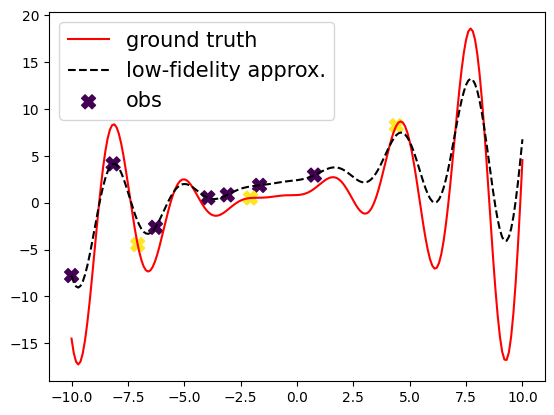

In [ ]:
plt.plot(xs, ys, label="ground truth", c="r")
plt.plot(xs, approx_ys, "k--", label="low-fidelity approx.")

plt.scatter(train_x, train_y, c=train_x_full[:, 1], cmap="viridis", marker="X", label="obs", s=100)

plt.legend(fontsize=15);

Run BO- 15 iterations

Step:1


sample: 100%|██████████| 4000/4000 [00:05<00:00, 725.34it/s, 15 steps of size 2.81e-01. acc. prob=0.90] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      0.80      0.59      0.69      0.00      1.59   1361.93      1.00
  k_length      0.02      0.01      0.02      0.00      0.04    642.62      1.00
   k_scale      8.26      1.59      8.16      5.49     10.72   1256.91      1.00
     noise      1.73      2.26      1.04      0.04      3.85   1184.26      1.00



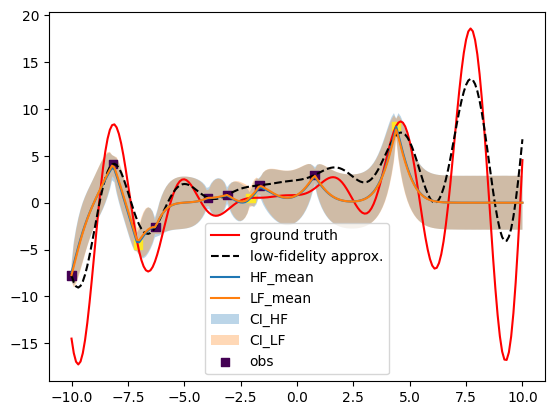

(402,)


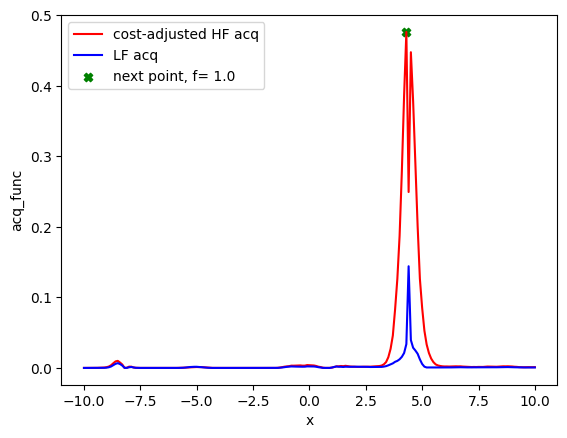

344
Step:2


sample: 100%|██████████| 4000/4000 [00:05<00:00, 713.60it/s, 7 steps of size 4.82e-01. acc. prob=0.90] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      0.82      0.59      0.73      0.00      1.64   1388.62      1.00
  k_length      0.03      0.01      0.03      0.01      0.04   1120.53      1.00
   k_scale      8.16      1.61      8.07      5.66     10.90   1816.86      1.00
     noise      1.69      2.13      1.04      0.03      3.60   1827.67      1.00



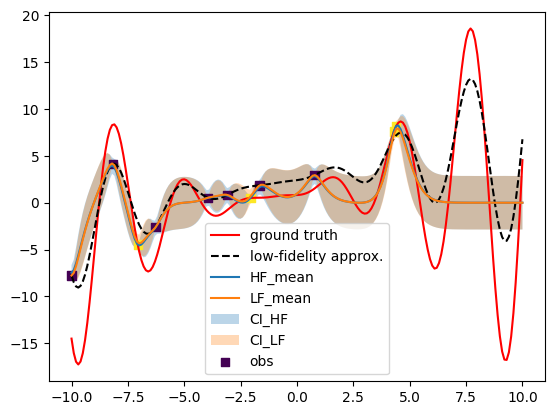

(402,)


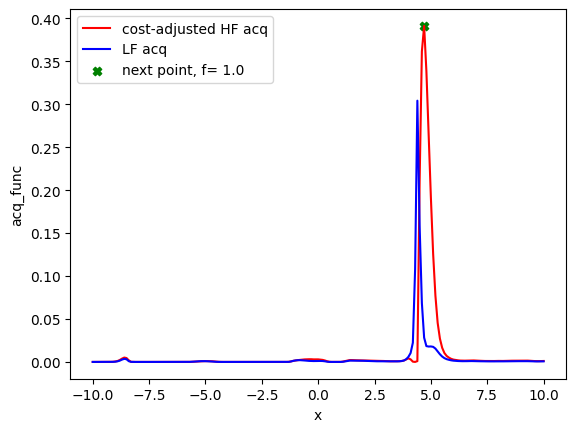

[344 348]
Step:3


sample: 100%|██████████| 4000/4000 [00:05<00:00, 717.37it/s, 7 steps of size 4.72e-01. acc. prob=0.91] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      0.82      0.60      0.71      0.00      1.63   1712.32      1.00
  k_length      0.03      0.01      0.03      0.02      0.04   1221.83      1.00
   k_scale      8.22      1.62      8.13      5.73     10.99   1946.60      1.00
     noise      1.78      2.37      1.06      0.03      3.76   1638.71      1.00



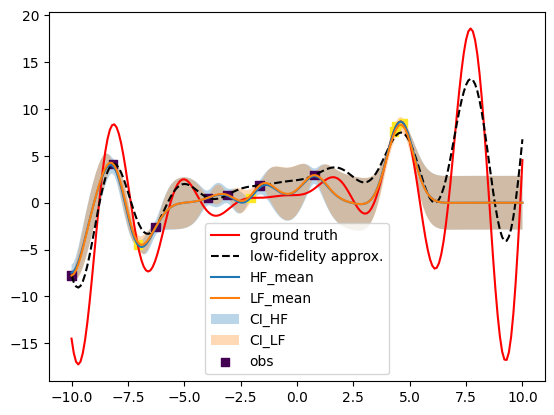

(402,)


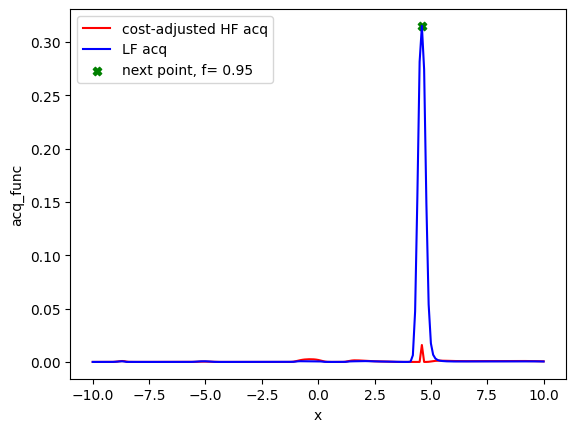

[344 348 146]
Step:4


sample: 100%|██████████| 4000/4000 [00:06<00:00, 665.93it/s, 7 steps of size 7.44e-01. acc. prob=0.86] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      1.07      0.52      0.98      0.32      1.86   1696.86      1.00
  k_length      0.03      0.01      0.03      0.02      0.04   1722.80      1.00
   k_scale      8.33      1.61      8.20      5.71     10.91   1704.37      1.00
     noise      1.73      2.63      1.00      0.05      3.77   1647.27      1.00



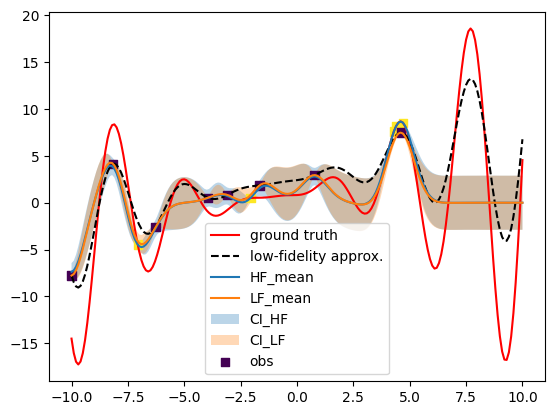

(402,)


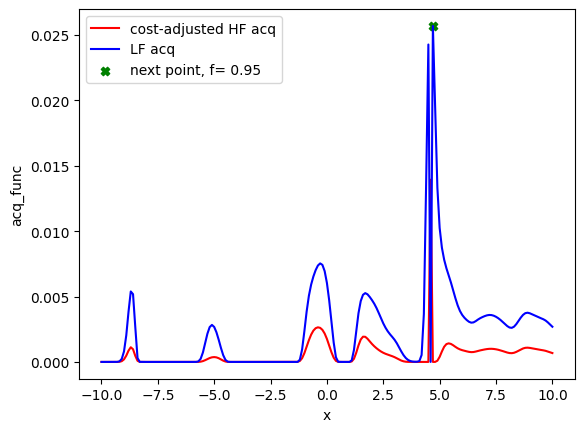

[344 348 146 147]
Step:5


sample: 100%|██████████| 4000/4000 [00:05<00:00, 705.66it/s, 7 steps of size 7.01e-01. acc. prob=0.89] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      0.99      0.50      0.90      0.22      1.68   2092.00      1.00
  k_length      0.03      0.01      0.03      0.02      0.04   1655.16      1.00
   k_scale      8.25      1.55      8.14      5.55     10.56   1850.72      1.00
     noise      1.77      2.85      0.98      0.03      3.86   1692.94      1.00



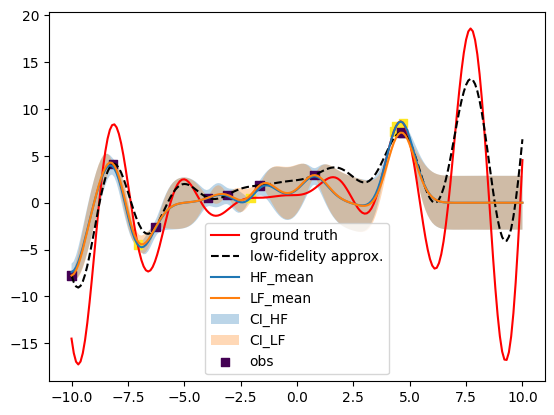

(402,)


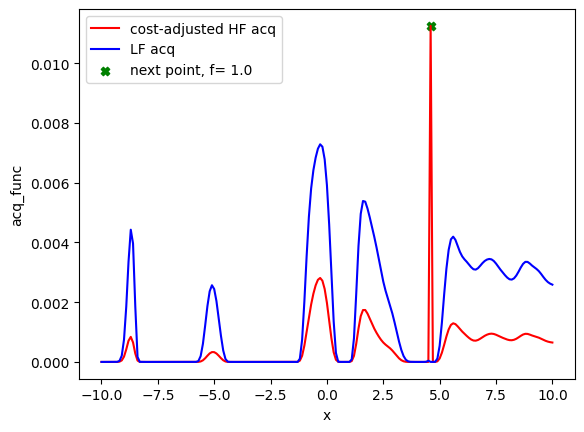

[344 348 146 147 347]
Step:6


sample: 100%|██████████| 4000/4000 [00:05<00:00, 700.14it/s, 7 steps of size 7.70e-01. acc. prob=0.86] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      1.02      0.51      0.93      0.29      1.79   1806.16      1.00
  k_length      0.03      0.00      0.03      0.03      0.04   1421.55      1.00
   k_scale      8.15      1.61      8.03      5.45     10.67   1441.57      1.00
     noise      1.72      2.48      1.01      0.05      3.68   1620.64      1.00



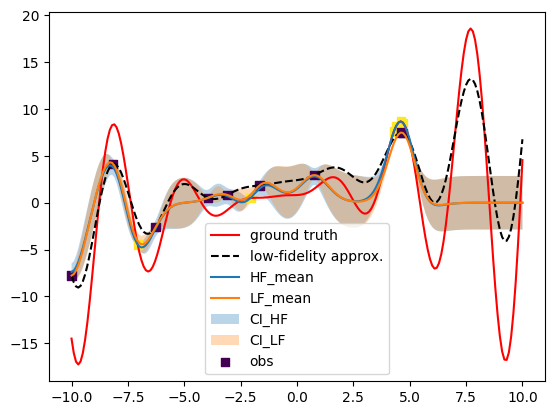

(402,)


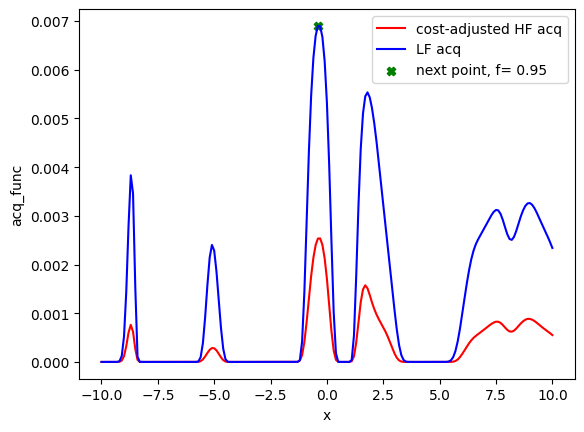

[344 348 146 147 347  96]
Step:7


sample: 100%|██████████| 4000/4000 [00:05<00:00, 705.11it/s, 7 steps of size 7.28e-01. acc. prob=0.89] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      1.02      0.49      0.94      0.30      1.75   1806.58      1.00
  k_length      0.03      0.00      0.03      0.03      0.04   1320.06      1.00
   k_scale      8.11      1.58      7.97      5.40     10.52   1820.13      1.00
     noise      1.72      2.79      0.96      0.03      3.86   1671.18      1.00



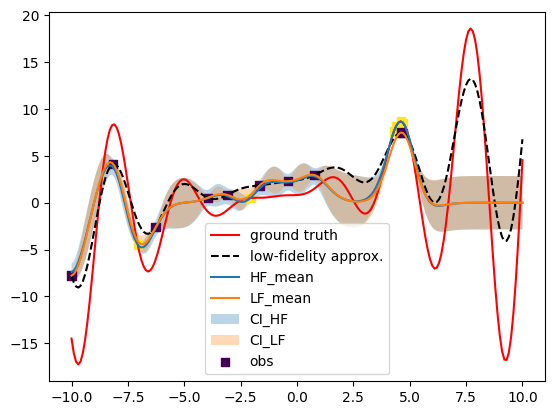

(402,)


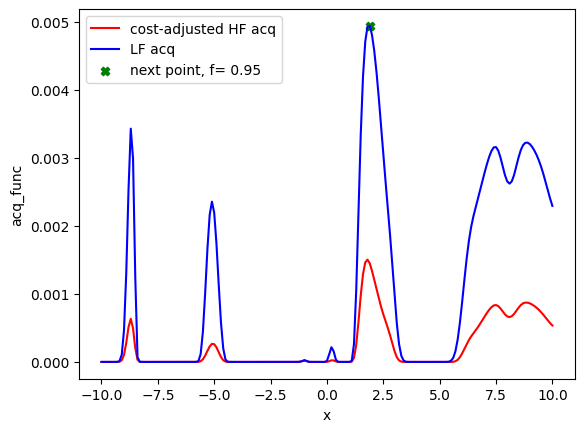

[344 348 146 147 347  96 119]
Step:8


sample: 100%|██████████| 4000/4000 [00:06<00:00, 602.20it/s, 7 steps of size 7.07e-01. acc. prob=0.90] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      1.02      0.51      0.94      0.29      1.78   2226.39      1.00
  k_length      0.03      0.00      0.03      0.03      0.04   1690.74      1.00
   k_scale      8.14      1.53      7.98      5.69     10.66   1688.44      1.00
     noise      1.72      2.72      0.97      0.03      3.74   1628.55      1.00



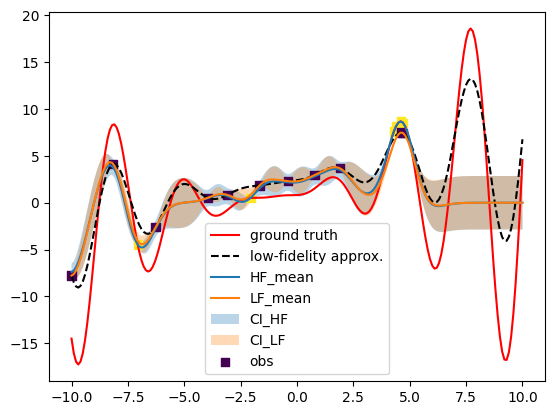

(402,)


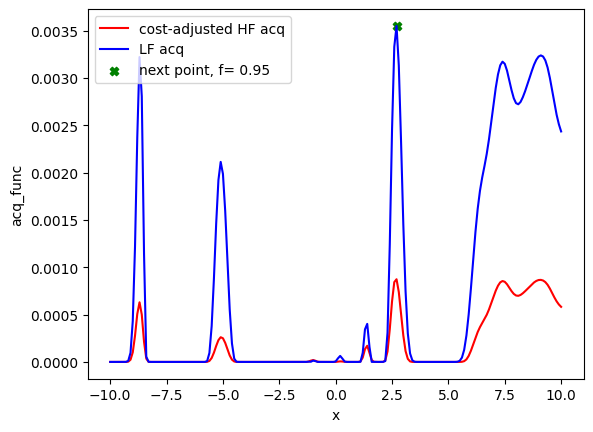

[344 348 146 147 347  96 119 127]
Step:9


sample: 100%|██████████| 4000/4000 [00:05<00:00, 675.58it/s, 7 steps of size 6.27e-01. acc. prob=0.92] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      1.04      0.53      0.95      0.26      1.78   2127.18      1.00
  k_length      0.03      0.00      0.03      0.03      0.04   1750.58      1.00
   k_scale      8.10      1.55      8.00      5.54     10.59   1979.82      1.00
     noise      1.69      2.30      1.02      0.05      3.60   1801.81      1.00



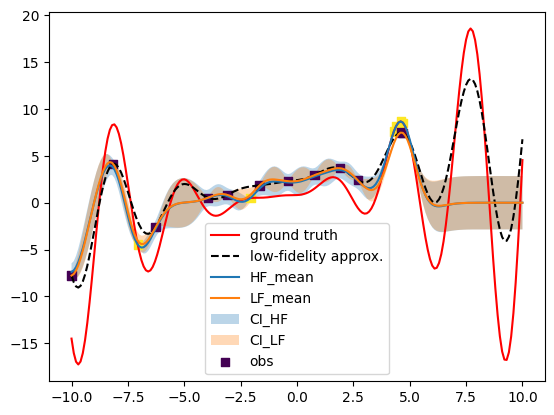

(402,)


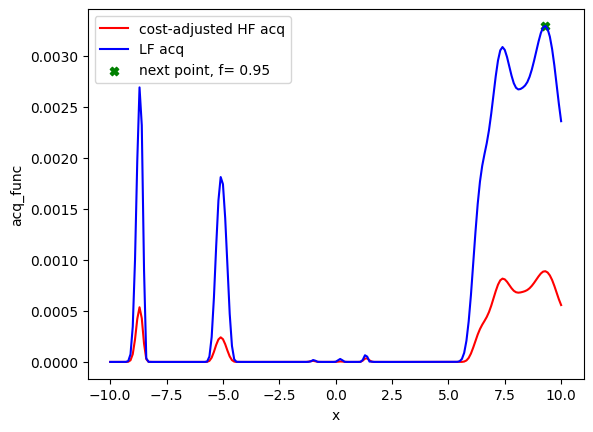

[344 348 146 147 347  96 119 127 193]
Step:10


sample: 100%|██████████| 4000/4000 [00:06<00:00, 576.24it/s, 7 steps of size 7.36e-01. acc. prob=0.87] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      1.02      0.51      0.93      0.27      1.74   2004.02      1.00
  k_length      0.03      0.00      0.03      0.03      0.04   1759.92      1.00
   k_scale      8.28      1.53      8.13      5.91     10.80   1671.71      1.00
     noise      1.80      2.87      1.04      0.05      3.95   1477.87      1.00



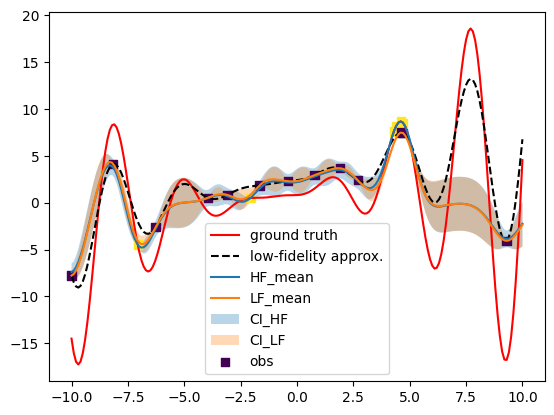

(402,)


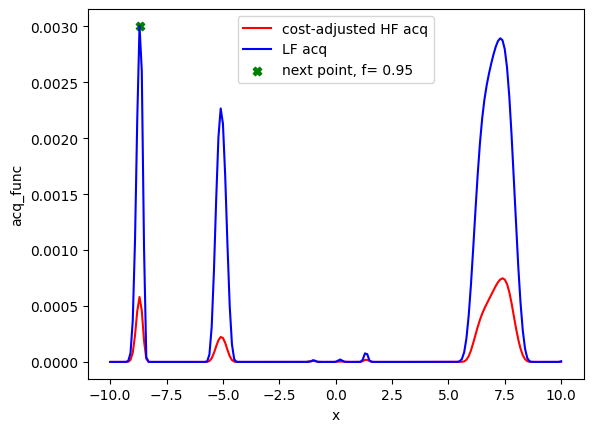

[344 348 146 147 347  96 119 127 193  13]
Step:11


sample: 100%|██████████| 4000/4000 [00:07<00:00, 559.20it/s, 7 steps of size 6.12e-01. acc. prob=0.92] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      1.03      0.51      0.93      0.25      1.74   2112.38      1.00
  k_length      0.03      0.00      0.03      0.03      0.04   1584.64      1.00
   k_scale      8.23      1.54      8.11      5.60     10.59   1939.24      1.00
     noise      1.70      2.37      1.00      0.03      3.67   1708.49      1.00



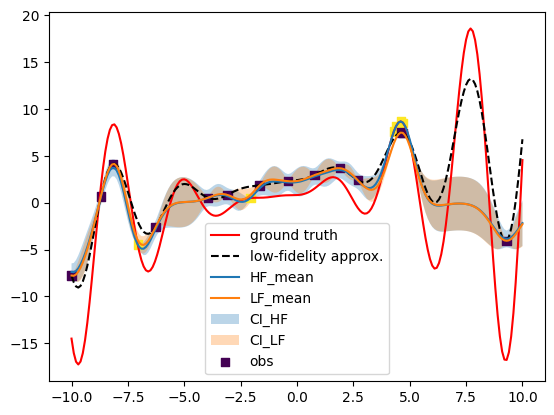

(402,)


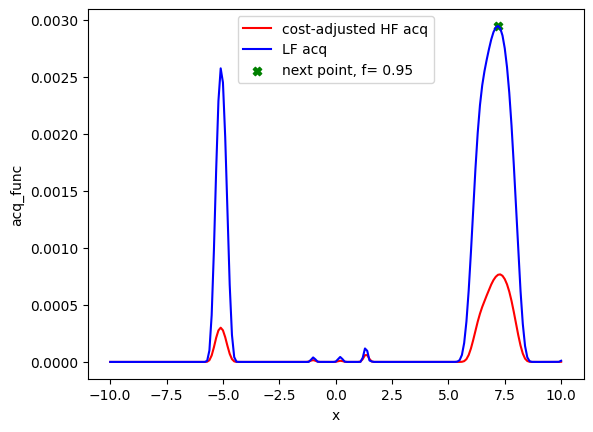

[344 348 146 147 347  96 119 127 193  13 172]
Step:12


sample: 100%|██████████| 4000/4000 [00:07<00:00, 548.76it/s, 7 steps of size 6.93e-01. acc. prob=0.88] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      0.97      0.51      0.88      0.23      1.71   1810.04      1.00
  k_length      0.03      0.00      0.03      0.03      0.04   1417.33      1.00
   k_scale      9.57      1.58      9.42      6.96     12.03   1723.51      1.00
     noise      1.70      2.52      0.98      0.03      3.81   1673.56      1.00



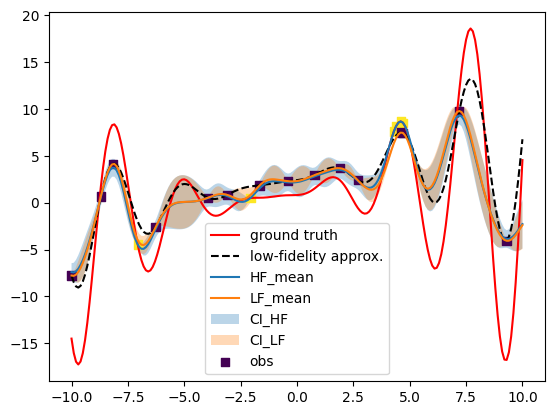

(402,)


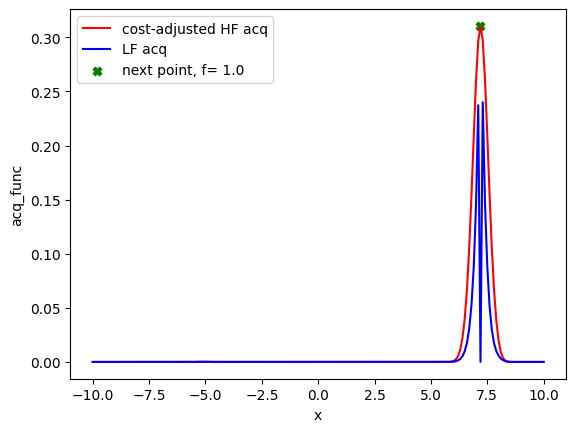

[344 348 146 147 347  96 119 127 193  13 172 373]
Step:13


sample: 100%|██████████| 4000/4000 [00:07<00:00, 513.31it/s, 7 steps of size 6.72e-01. acc. prob=0.90] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      1.34      0.50      1.29      0.50      2.04   2106.69      1.00
  k_length      0.03      0.00      0.03      0.03      0.04   1307.79      1.00
   k_scale     10.19      1.61     10.04      7.48     12.77   1786.97      1.00
     noise      1.70      2.49      0.99      0.03      3.66   1680.50      1.00



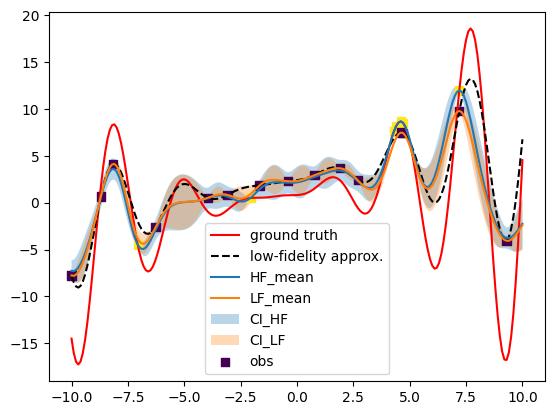

(402,)


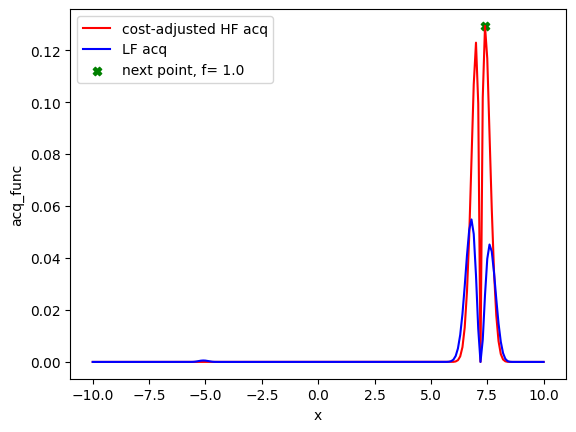

[344 348 146 147 347  96 119 127 193  13 172 373 375]
Step:14


sample: 100%|██████████| 4000/4000 [00:07<00:00, 508.44it/s, 7 steps of size 6.75e-01. acc. prob=0.92] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      1.27      0.50      1.21      0.47      1.99   2079.58      1.00
  k_length      0.03      0.00      0.03      0.02      0.03   2054.89      1.00
   k_scale     11.67      1.64     11.56      8.89     14.29   1801.67      1.00
     noise      1.71      2.65      0.99      0.03      3.70   1726.76      1.00



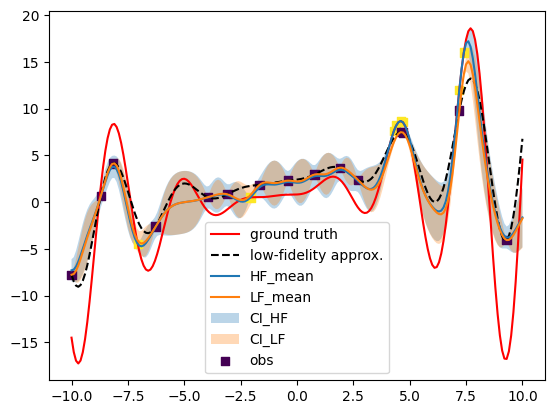

(402,)


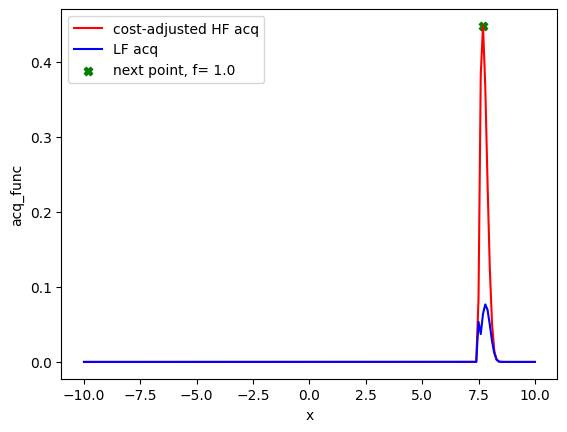

[344 348 146 147 347  96 119 127 193  13 172 373 375 378]
Step:15


sample: 100%|██████████| 4000/4000 [00:07<00:00, 509.32it/s, 7 steps of size 8.05e-01. acc. prob=0.88] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      1.25      0.50      1.18      0.48      1.98   1960.29      1.00
  k_length      0.03      0.00      0.03      0.03      0.04   2202.70      1.00
   k_scale     11.98      1.65     11.89      9.05     14.51   1676.54      1.00
     noise      1.64      2.48      0.95      0.04      3.37   1782.43      1.00



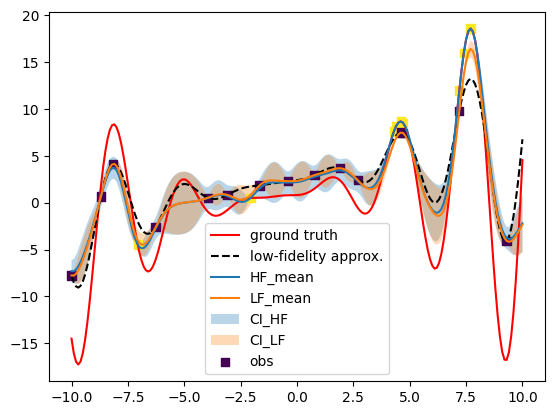

(402,)


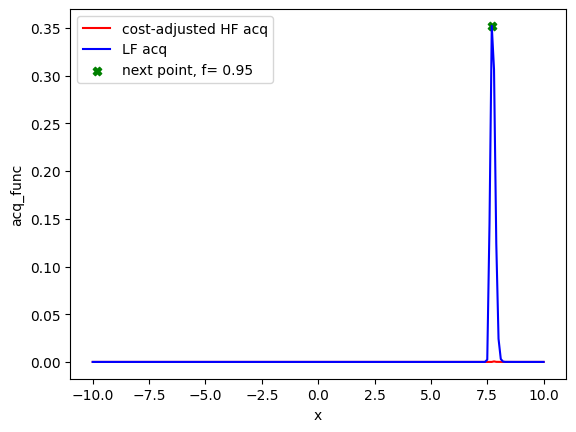

[344 348 146 147 347  96 119 127 193  13 172 373 375 378 177]


In [ ]:
N = 15
cost_ratio = 5/4
f = np.array([1.0, 2.0])
X_test_hf = np.transpose(np.vstack([xs, np.ones_like(xs)*fidelities[0]]))
X_test_lf = np.transpose(np.vstack([xs, np.ones_like(xs)*fidelities[1]]))
X_test =np.vstack((X_test_hf, X_test_lf))
X_test_full = np.vstack((X_test_hf, X_test_lf))
X_test_norm = np.vstack((X_test_hf, X_test_lf))
X_test_norm[:, 0] = (X_test[:, 0]-bounds[0])/(bounds[1]-bounds[0])

# Get random number generator keys for training and prediction
rng_key, rng_key_predict = gpax.utils.get_keys()
idx = []
for i in range(1, N+1):
    print("Step:"+str(i))


    # Initialize MF model
    gp_model = gpax.ExactGP(1, kernel= fidelity_kernel, kernel_prior = fidelity_kernel_prior)
    # Run Hamiltonian Monte Carlo to obtain posterior samples for kernel parameters and model noise
    gp_model.fit(rng_key, train_x_full_norm, train_y, num_chains=1)


    if ((i == 1) or ((i % 1) == 0)): # Check predictions after every 5 BO runs
        y_pred, y_sampled = gp_model.predict(rng_key_predict, X_test_norm[X_test_lf.shape[0]:, :], n=200)
        y_pred_lf, y_sampled_lf = gp_model.predict(rng_key_predict, X_test_norm[0:X_test_lf.shape[0], :], n=200)
        plt.plot(xs, ys, label="ground truth", c="r")
        plt.plot(xs, approx_ys, "k--", label="low-fidelity approx.")
        pred_lower = y_pred - y_sampled.std(axis=(0,1))
        pred_upper = y_pred + y_sampled.std(axis=(0,1))
        pred_lower_lf = y_pred_lf - y_sampled_lf.std(axis=(0,1))
        pred_upper_lf = y_pred_lf + y_sampled_lf.std(axis=(0,1))
        plt.plot(xs, y_pred, label="HF_mean")
        plt.plot(xs, y_pred_lf, label="LF_mean")
        plt.fill_between(
            xs.flatten(),
            pred_lower,
            pred_upper,
            alpha=0.3,
            label="CI_HF",
        )

        plt.fill_between(
            xs.flatten(),
            pred_lower_lf,
            pred_upper_lf,
            alpha=0.3,
            label="CI_LF",
        )

        plt.scatter(train_x_full[:, 0], train_y, c=train_x_full[:, 1], cmap="viridis", marker="s", label="obs")

        plt.legend(loc="best")
        plt.show()
    # Compute the MF acq function - EI based
    test_data = [X_test, X_test_norm]
    acq, next_point_idx, next_point_val  = fidelity_acqfun(gp_model, test_data, f, cost_ratio, rng_key_predict, idx, isnorm=True)
    idx = np.hstack((idx, next_point_idx))
    if i == 1:
        idx = int(idx)
        print(idx)
    else:
        idx = idx
        print(idx)

    # acq = gpax.acquisition.EI(rng_key_predict, gp_model, X_test, maximize=True, noiseless=True)
    # acq = gpax.acquisition.UCB(rng_key_predict, gp_model, X_test, beta=4, maximize=True, noiseless=True)
    if next_point_val == 0:
        print("Model sufficiently learned")
        break
    else:
        next_point = X_test[next_point_idx]
        next_point_norm = X_test_norm[next_point_idx]
        train_x_full = np.vstack((train_x_full, next_point))
        train_x_full_norm = np.vstack((train_x_full_norm, next_point_norm))
        #print(next_point_idx, next_point, next_point_norm, train_x_full, train_x_full_norm)

        train_y = evaluate_all_functions(train_x_full)

    #X_test = np.concatenate([X_test[:next_point_idx], X_test[next_point_idx+1:]])
    #print(X_test.shape)

In [ ]:
train_x_full

array([[-1.65955991,  0.95      ],
       [ 4.40648987,  1.        ],
       [-9.9977125 ,  0.95      ],
       [-3.95334855,  0.95      ],
       [-7.06488218,  1.        ],
       [-8.1532281 ,  0.95      ],
       [-6.27479577,  0.95      ],
       [-3.08878546,  0.95      ],
       [-2.06465052,  1.        ],
       [ 0.77633468,  0.95      ],
       [ 4.3       ,  1.        ],
       [ 4.7       ,  1.        ],
       [ 4.6       ,  0.95      ],
       [ 4.7       ,  0.95      ],
       [ 4.6       ,  1.        ],
       [-0.4       ,  0.95      ],
       [ 1.9       ,  0.95      ],
       [ 2.7       ,  0.95      ],
       [ 9.3       ,  0.95      ],
       [-8.7       ,  0.95      ],
       [ 7.2       ,  0.95      ],
       [ 7.2       ,  1.        ],
       [ 7.4       ,  1.        ],
       [ 7.7       ,  1.        ],
       [ 7.7       ,  0.95      ]])

#Test Problem 2

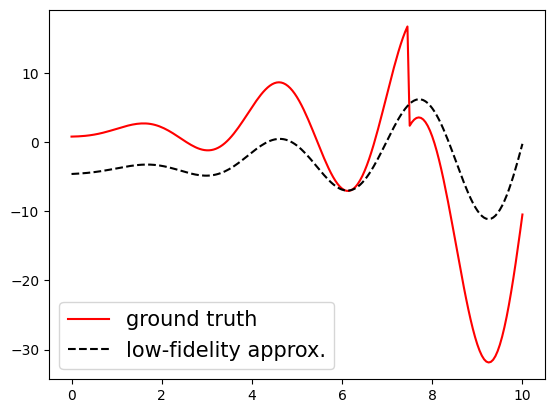

In [ ]:
def dobjective(x):
    # a modification of https://www.sfu.ca/~ssurjano/forretal08.html
    y = np.zeros_like(x)
    for i in range(x.shape[0]):
        if x[i] < 7.5:
            y[i] = -((x[i] + 1) ** 2) * np.sin(2 * x[i] + 2) / 5 + 1 + x[i] / 3
        elif x[i] >=7.5:
            y[i] = -((x[i] + 1) ** 2) * np.sin(2 * x[i] + 2) / 5 + 1 + x[i] / 3 - 15
    return y

def objective(x):
    # a modification of https://www.sfu.ca/~ssurjano/forretal08.html
    y = -((x + 1) ** 2) * np.sin(2 * x + 2) / 5 + 1 + x / 3
    return y

def approx_objective(x):
        return 0.5 * objective(x) + x / 4 -5


def evaluate_all_functions(x_full):
    y = []
    for x in x_full:
        if np.isclose(x[-1], np.ones(1)):
            y.append(dobjective(x[:-1]))
        else:
            y.append(approx_objective(x[:-1]))

    return np.asarray(y)


lb = 0
ub = 10

bounds = np.array((lb, ub), dtype=float)
fidelities = np.array((0.95, 1.0))

xs = np.linspace(lb, ub, 201)

ys = dobjective(xs)
approx_ys = approx_objective(xs)


plt.plot(xs, ys, label="ground truth", c="r")
plt.plot(xs, approx_ys, "k--", label="low-fidelity approx.")

plt.legend(fontsize=15);

Here the high-fid function has discontinuity (at the optimal point) whereas the low-fidelity function is a cont. function

# Run first 10 samples randomly

In [ ]:
n = 10

np.random.seed(100)
train_x = bounds[0] + (bounds[1] - bounds[0]) * np.random.rand(n, 1)
train_x_norm = (train_x-bounds[0])/(bounds[1]-bounds[0])
train_f = fidelities[np.random.randint(0, 2, (n, 1))]  # mixed fidelity
#train_f = torch.ones_like(train_x) * fidelities[0]  # only the low fidelity
train_x_full = np.concatenate((train_x, train_f), axis=1)
train_x_full_norm = np.concatenate((train_x_norm, train_f), axis=1)
train_x_full, train_x_full_norm

(array([[5.43404942, 0.95      ],
        [2.78369385, 1.        ],
        [4.24517591, 0.95      ],
        [8.44776132, 0.95      ],
        [0.04718856, 0.95      ],
        [1.21569121, 1.        ],
        [6.70749085, 1.        ],
        [8.25852755, 1.        ],
        [1.3670659 , 0.95      ],
        [5.75093329, 0.95      ]]),
 array([[0.54340494, 0.95      ],
        [0.27836939, 1.        ],
        [0.42451759, 0.95      ],
        [0.84477613, 0.95      ],
        [0.00471886, 0.95      ],
        [0.12156912, 1.        ],
        [0.67074908, 1.        ],
        [0.82585276, 1.        ],
        [0.13670659, 0.95      ],
        [0.57509333, 0.95      ]]))

In [ ]:
train_y = evaluate_all_functions(train_x_full)
train_y

array([[-3.46601045],
       [-0.81858374],
       [-0.32370422],
       [-1.39025485],
       [-4.57530777],
       [ 2.3485763 ],
       [-0.19552183],
       [-5.65119885],
       [-3.37022155],
       [-5.77208799]])

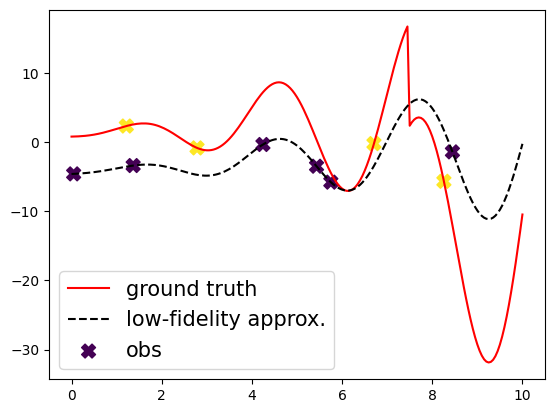

In [ ]:
plt.plot(xs, ys, label="ground truth", c="r")
plt.plot(xs, approx_ys, "k--", label="low-fidelity approx.")

plt.scatter(train_x, train_y, c=train_x_full[:, 1], cmap="viridis", marker="X", label="obs", s=100)

plt.legend(fontsize=15);

In [ ]:
X_test_hf = np.transpose(np.vstack([xs, np.ones_like(xs)*fidelities[0]]))
X_test_lf = np.transpose(np.vstack([xs, np.ones_like(xs)*fidelities[1]]))
X_test =np.vstack((X_test_hf, X_test_lf))
X_test_full = np.vstack((X_test_hf, X_test_lf))
X_test_norm = np.vstack((X_test_hf, X_test_lf))
X_test_norm[:, 0] = (X_test[:, 0]-bounds[0])/(bounds[1]-bounds[0])

# MFGP

- On a discontinuous high-fid function where GP does not have any prior knowledge

Step:1


sample: 100%|██████████| 4000/4000 [00:06<00:00, 658.46it/s, 7 steps of size 4.37e-01. acc. prob=0.88] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      0.86      0.61      0.75      0.00      1.70   1351.32      1.01
  k_length      0.01      0.01      0.01      0.00      0.02   1396.19      1.00
   k_scale      6.84      1.55      6.70      4.42      9.40   1611.10      1.00
     noise      1.76      2.29      1.03      0.05      4.16   1190.33      1.00



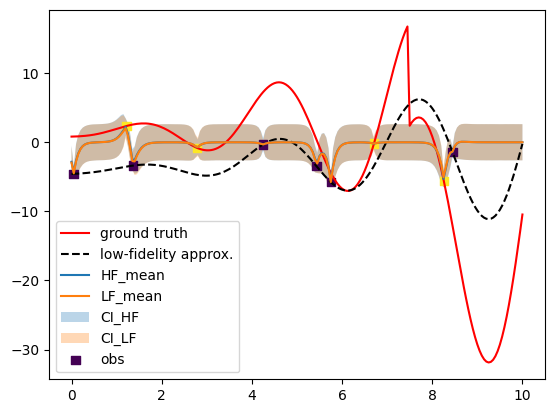

(402,)


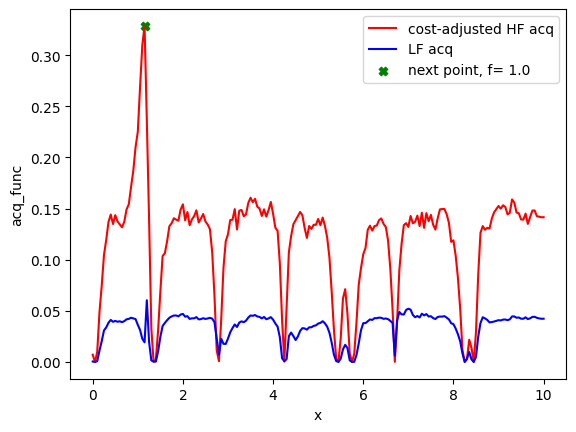

224
Step:2


sample: 100%|██████████| 4000/4000 [00:06<00:00, 653.78it/s, 7 steps of size 5.23e-01. acc. prob=0.73] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      0.83      0.61      0.73      0.00      1.63   1094.21      1.00
  k_length      0.01      0.00      0.01      0.00      0.01    749.64      1.00
   k_scale      6.71      1.54      6.56      4.06      8.98   1046.72      1.00
     noise      1.77      2.61      0.99      0.04      3.75   1236.00      1.00

(402,)


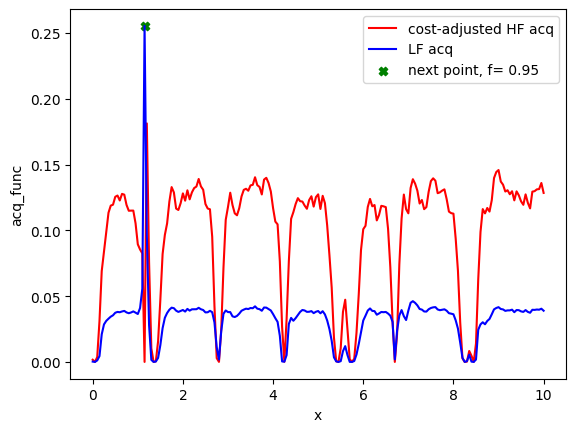

[224  23]
Step:3


sample: 100%|██████████| 4000/4000 [00:05<00:00, 676.29it/s, 7 steps of size 5.17e-01. acc. prob=0.91] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      2.88      0.60      2.83      1.93      3.84   1880.70      1.00
  k_length      0.05      0.01      0.05      0.03      0.08   1559.61      1.00
   k_scale      9.15      1.67      9.04      6.20     11.64   1460.48      1.00
     noise      1.67      2.22      0.99      0.04      3.71   1663.86      1.00

(402,)


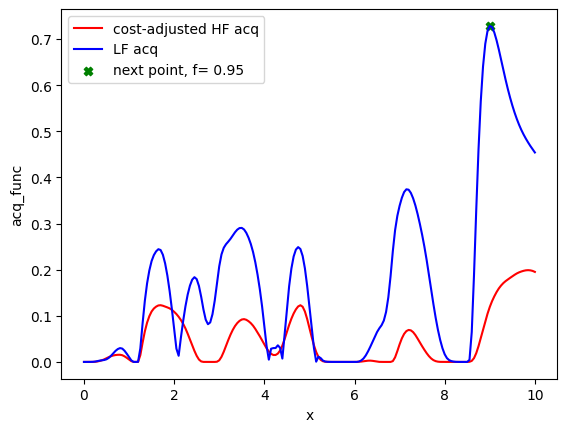

[224  23 180]
Step:4


sample: 100%|██████████| 4000/4000 [00:06<00:00, 592.87it/s, 7 steps of size 5.64e-01. acc. prob=0.93] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      2.71      0.59      2.68      1.75      3.66   1946.68      1.00
  k_length      0.03      0.01      0.03      0.01      0.04   1895.65      1.00
   k_scale     10.44      1.72     10.33      7.48     13.15   1755.62      1.00
     noise      1.69      2.36      1.00      0.03      3.65   1808.83      1.00

(402,)


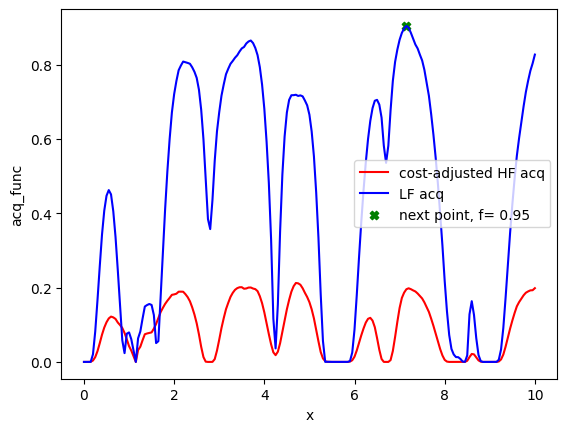

[224  23 180 143]
Step:5


sample: 100%|██████████| 4000/4000 [00:06<00:00, 624.73it/s, 7 steps of size 7.15e-01. acc. prob=0.88] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      2.72      0.60      2.68      1.74      3.68   1711.72      1.00
  k_length      0.03      0.01      0.03      0.01      0.04   1528.41      1.00
   k_scale     10.37      1.70     10.28      7.90     13.48   1780.93      1.00
     noise      1.74      2.66      0.97      0.05      3.98   1611.47      1.00



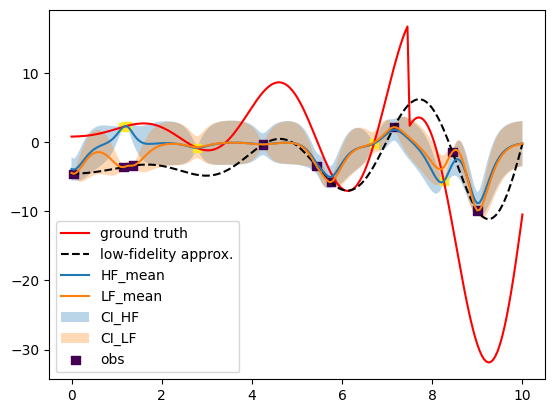

(402,)


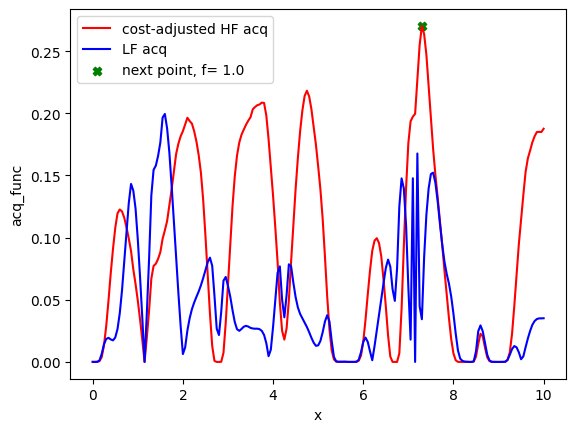

[224  23 180 143 347]
Step:6


sample: 100%|██████████| 4000/4000 [00:06<00:00, 601.00it/s, 7 steps of size 5.70e-01. acc. prob=0.85] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      2.52      0.57      2.48      1.63      3.47   1669.29      1.00
  k_length      0.01      0.01      0.01      0.00      0.02   1284.21      1.00
   k_scale     12.38      1.71     12.22      9.68     15.13   1621.03      1.00
     noise      1.69      2.30      1.01      0.05      3.73   1487.17      1.00

(402,)


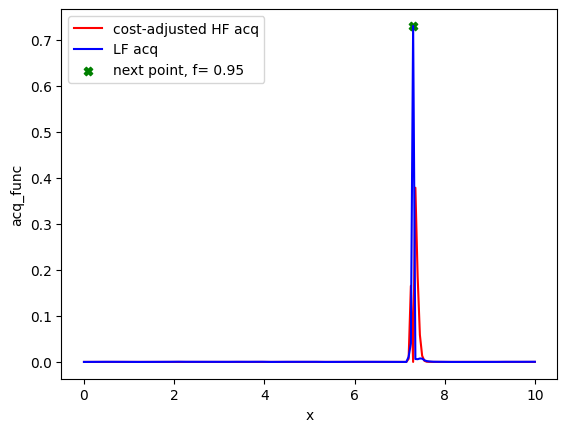

[224  23 180 143 347 146]
Step:7


sample: 100%|██████████| 4000/4000 [00:06<00:00, 628.88it/s, 7 steps of size 6.15e-01. acc. prob=0.92] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      3.76      0.58      3.72      2.81      4.70   1860.56      1.00
  k_length      0.03      0.01      0.03      0.02      0.04   1316.36      1.00
   k_scale     13.49      1.76     13.35     10.66     16.39   1965.28      1.00
     noise      1.70      2.42      0.99      0.04      3.69   1741.07      1.00

(402,)


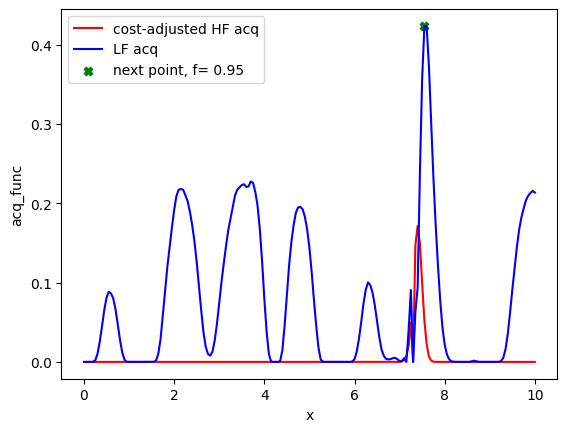

[224  23 180 143 347 146 151]
Step:8


sample: 100%|██████████| 4000/4000 [00:06<00:00, 604.46it/s, 7 steps of size 7.12e-01. acc. prob=0.89] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      3.78      0.58      3.75      2.81      4.71   1726.64      1.00
  k_length      0.03      0.01      0.03      0.02      0.04   1687.85      1.00
   k_scale     13.55      1.73     13.44     10.60     16.28   1741.23      1.00
     noise      1.74      2.45      1.02      0.03      3.76   1498.43      1.00

(402,)


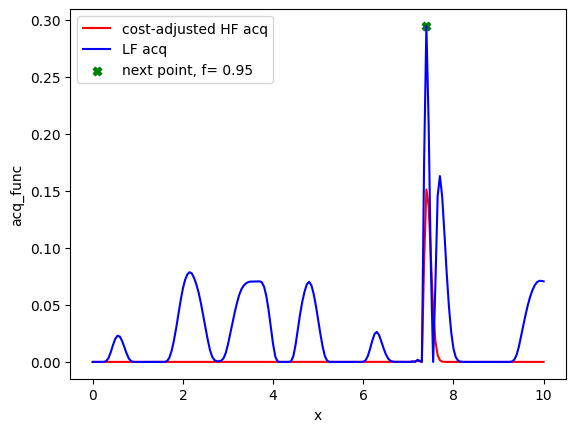

[224  23 180 143 347 146 151 148]
Step:9


sample: 100%|██████████| 4000/4000 [00:07<00:00, 567.57it/s, 3 steps of size 6.92e-01. acc. prob=0.91] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      3.81      0.57      3.78      2.94      4.79   1714.96      1.00
  k_length      0.03      0.01      0.03      0.02      0.04   1455.84      1.00
   k_scale     13.70      1.74     13.56     10.64     16.37   1946.55      1.00
     noise      1.76      2.77      1.00      0.04      3.81   1457.22      1.00

(402,)


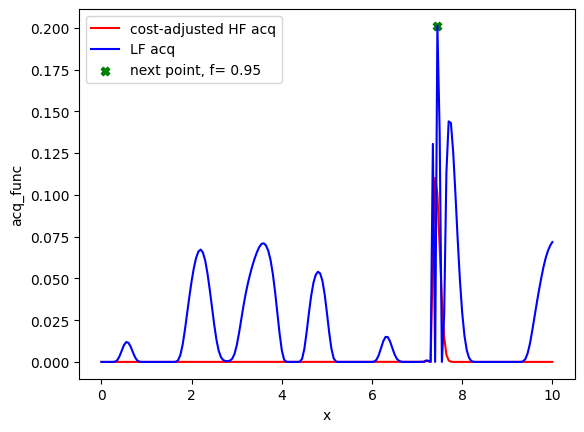

[224  23 180 143 347 146 151 148 149]
Step:10


sample: 100%|██████████| 4000/4000 [00:07<00:00, 548.35it/s, 5 steps of size 7.13e-01. acc. prob=0.88] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      3.94      0.58      3.90      2.97      4.86   1713.09      1.00
  k_length      0.04      0.01      0.04      0.03      0.05   1514.53      1.00
   k_scale     13.91      1.69     13.85     11.02     16.52   1651.23      1.00
     noise      1.70      2.74      0.98      0.03      3.66   1494.51      1.00



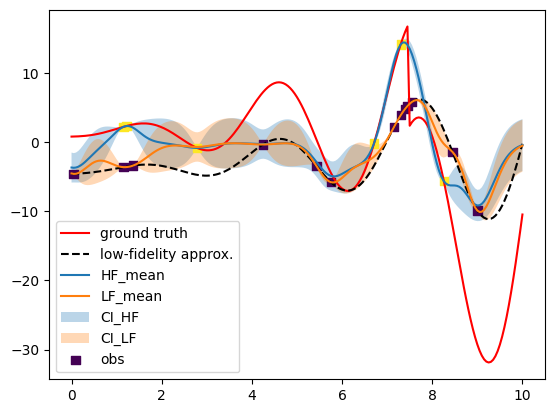

(402,)


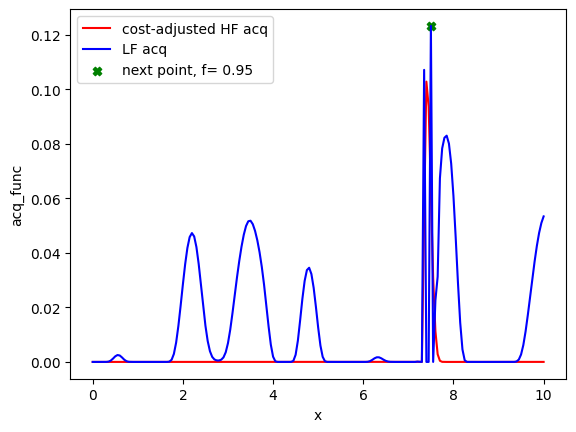

[224  23 180 143 347 146 151 148 149 150]
Step:11


sample: 100%|██████████| 4000/4000 [00:06<00:00, 573.38it/s, 5 steps of size 6.96e-01. acc. prob=0.90] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      4.00      0.59      3.96      3.01      4.92   1803.47      1.00
  k_length      0.04      0.01      0.04      0.03      0.05   1339.73      1.00
   k_scale     14.05      1.74     13.91     11.18     16.89   1753.02      1.00
     noise      1.70      2.68      0.96      0.04      3.62   1454.74      1.00

(402,)


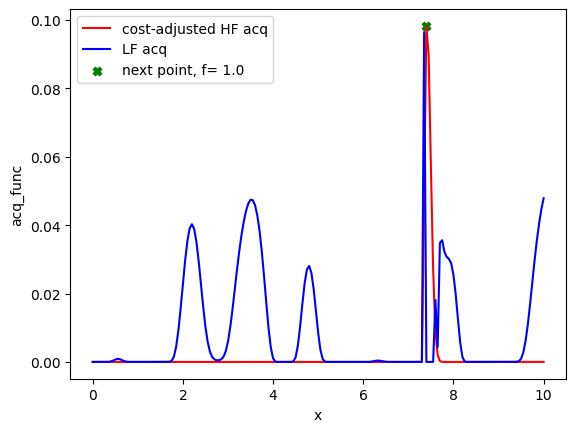

[224  23 180 143 347 146 151 148 149 150 349]
Step:12


sample: 100%|██████████| 4000/4000 [00:07<00:00, 532.41it/s, 7 steps of size 6.37e-01. acc. prob=0.93] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      4.00      0.60      3.98      2.96      4.90   2205.74      1.00
  k_length      0.03      0.00      0.03      0.03      0.04   2279.28      1.00
   k_scale     14.21      1.73     14.09     11.54     17.12   1961.53      1.00
     noise      1.68      2.35      0.98      0.03      3.68   1686.48      1.00

(402,)


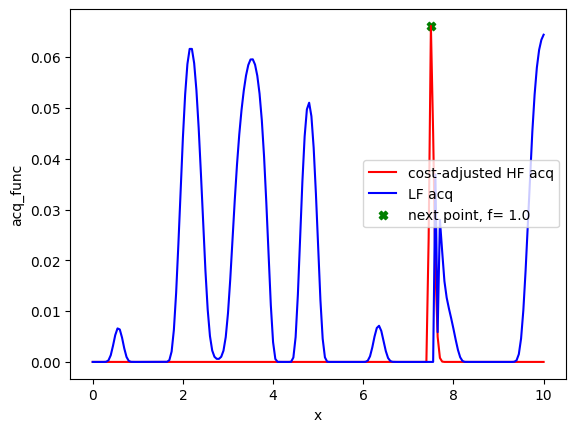

[224  23 180 143 347 146 151 148 149 150 349 351]
Step:13


sample: 100%|██████████| 4000/4000 [00:17<00:00, 230.16it/s, 7 steps of size 2.94e-01. acc. prob=0.92] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      4.36      0.58      4.34      3.40      5.27   2187.98      1.00
  k_length      0.01      0.00      0.01      0.01      0.01   1773.69      1.00
   k_scale     15.12      1.72     15.04     12.25     17.93   2388.49      1.00
     noise      1.82      2.40      1.07      0.05      4.31    708.49      1.00

(402,)


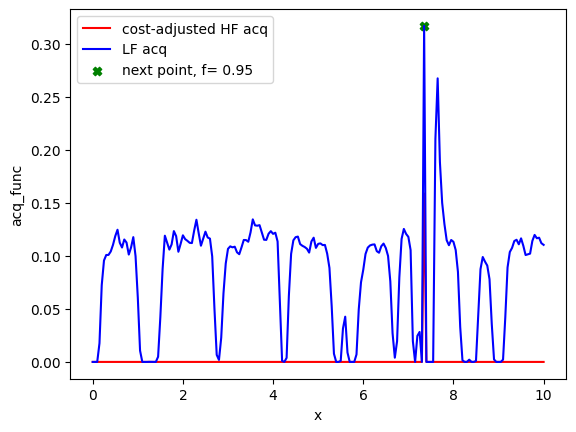

[224  23 180 143 347 146 151 148 149 150 349 351 147]
Step:14


sample: 100%|██████████| 4000/4000 [00:08<00:00, 485.90it/s, 7 steps of size 7.23e-01. acc. prob=0.90] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      4.40      0.58      4.39      3.40      5.31   1616.88      1.00
  k_length      0.01      0.00      0.01      0.01      0.01   2047.79      1.00
   k_scale     15.08      1.73     15.03     12.06     17.78   1727.28      1.00
     noise      1.72      2.83      0.95      0.05      3.76   1734.29      1.00

(402,)


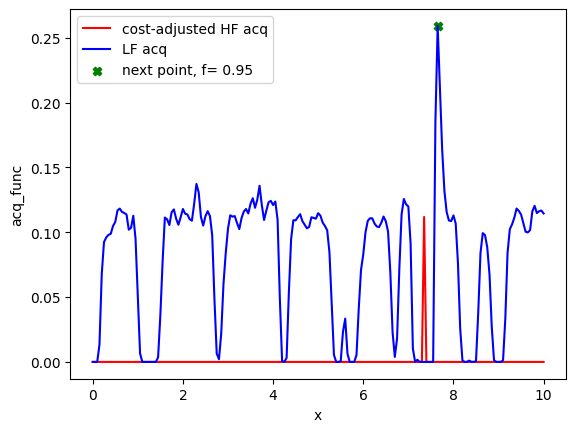

[224  23 180 143 347 146 151 148 149 150 349 351 147 153]
Step:15


sample: 100%|██████████| 4000/4000 [00:07<00:00, 507.68it/s, 7 steps of size 6.99e-01. acc. prob=0.91] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      4.44      0.58      4.43      3.54      5.47   1804.82      1.00
  k_length      0.01      0.00      0.01      0.01      0.01   1780.77      1.00
   k_scale     15.16      1.70     15.07     12.43     17.93   1866.40      1.00
     noise      1.74      2.37      1.01      0.06      3.79   1602.68      1.00



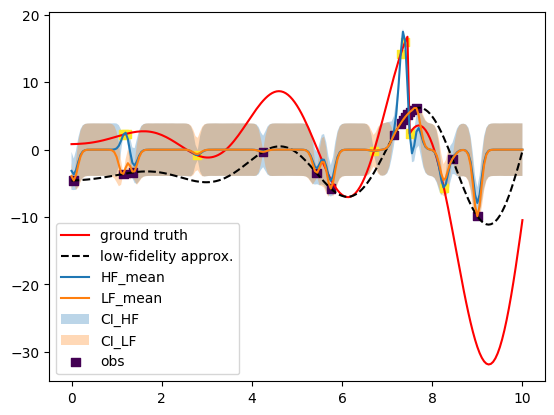

(402,)


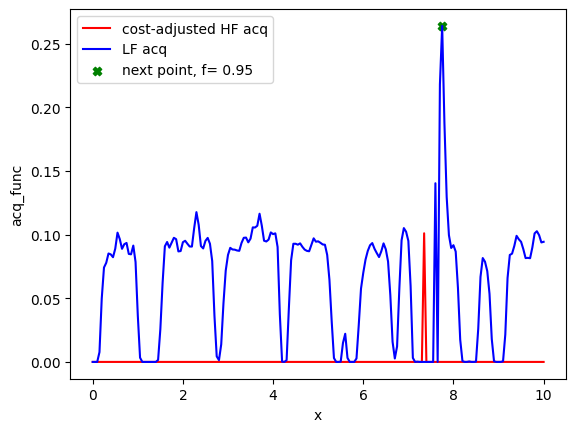

[224  23 180 143 347 146 151 148 149 150 349 351 147 153 155]


In [ ]:
N = 15
cost_ratio = 2
f = np.array([1.0, 2.0])
# Get random number generator keys for training and prediction
rng_key, rng_key_predict = gpax.utils.get_keys()
idx = []
for i in range(1, N+1):
    print("Step:"+str(i))

    # Multi-fidelity structured GP
    gp_model = gpax.ExactGP(1, kernel= fidelity_kernel, kernel_prior = fidelity_kernel_prior)
    # Run MCMC to obtain posterior samples
    gp_model.fit(rng_key, train_x_full_norm, train_y, num_chains=1)


    if ((i == 1) or ((i % 5) == 0)): # Check predictions after every 5 BO runs
        y_pred, y_sampled = gp_model.predict(rng_key_predict, X_test_norm[X_test_lf.shape[0]:, :], n=200)
        y_pred_lf, y_sampled_lf = gp_model.predict(rng_key_predict, X_test_norm[0:X_test_lf.shape[0], :], n=200)
        plt.plot(xs, ys, label="ground truth", c="r")
        plt.plot(xs, approx_ys, "k--", label="low-fidelity approx.")
        pred_lower = y_pred - y_sampled.std(axis=(0,1))
        pred_upper = y_pred + y_sampled.std(axis=(0,1))
        pred_lower_lf = y_pred_lf - y_sampled_lf.std(axis=(0,1))
        pred_upper_lf = y_pred_lf + y_sampled_lf.std(axis=(0,1))
        plt.plot(xs, y_pred, label="HF_mean")
        plt.plot(xs, y_pred_lf, label="LF_mean")
        plt.fill_between(
            xs.flatten(),
            pred_lower,
            pred_upper,
            alpha=0.3,
            label="CI_HF",
        )

        plt.fill_between(
            xs.flatten(),
            pred_lower_lf,
            pred_upper_lf,
            alpha=0.3,
            label="CI_LF",
        )

        plt.scatter(train_x_full[:, 0], train_y, c=train_x_full[:, 1], cmap="viridis", marker="s", label="obs")

        plt.legend(loc="best")
        plt.show()
    # Compute the MF acq function - EI based
    test_data = [X_test, X_test_norm]
    acq, next_point_idx, next_point_val  = fidelity_acqfun(gp_model, test_data, f, cost_ratio, rng_key_predict, idx, isnorm=True)
    idx = np.hstack((idx, next_point_idx))
    if i == 1:
        idx = int(idx)
        print(idx)
    else:
        idx = idx
        print(idx)

    # acq = gpax.acquisition.EI(rng_key_predict, gp_model, X_test, maximize=True, noiseless=True)
    # acq = gpax.acquisition.UCB(rng_key_predict, gp_model, X_test, beta=4, maximize=True, noiseless=True)
    if next_point_val == 0:
        print("Model sufficiently learned")
        break
    else:
        next_point = X_test[next_point_idx]
        next_point_norm = X_test_norm[next_point_idx]
        train_x_full = np.vstack((train_x_full, next_point))
        train_x_full_norm = np.vstack((train_x_full_norm, next_point_norm))
        #print(next_point_idx, next_point, next_point_norm, train_x_full, train_x_full_norm)

        train_y = evaluate_all_functions(train_x_full)

    #X_test = np.concatenate([X_test[:next_point_idx], X_test[next_point_idx+1:]])
    #print(X_test.shape)

In [ ]:
train_x_full

array([[5.43404942, 0.95      ],
       [2.78369385, 1.        ],
       [4.24517591, 0.95      ],
       [8.44776132, 0.95      ],
       [0.04718856, 0.95      ],
       [1.21569121, 1.        ],
       [6.70749085, 1.        ],
       [8.25852755, 1.        ],
       [1.3670659 , 0.95      ],
       [5.75093329, 0.95      ],
       [1.15      , 1.        ],
       [1.15      , 0.95      ],
       [9.        , 0.95      ],
       [7.15      , 0.95      ],
       [7.3       , 1.        ],
       [7.3       , 0.95      ],
       [7.55      , 0.95      ],
       [7.4       , 0.95      ],
       [7.45      , 0.95      ],
       [7.5       , 0.95      ],
       [7.4       , 1.        ],
       [7.5       , 1.        ],
       [7.35      , 0.95      ],
       [7.65      , 0.95      ],
       [7.75      , 0.95      ]])

# Now lets design the MFBO with structured MFGP

# Defining prioir mean function of GP with hyperprior learnable parameters

In [ ]:
@jit
def mean_func(x: jnp.ndarray, params: Dict[str, float]) -> jnp.ndarray:

    x_data = x[:,0]
    #jax.debug.print("x_norm: {}", x_data)
    lb = 0
    ub = 10
    x_data = x_data*(ub-lb) + lb
    #jax.debug.print("x: {}", x_data)

    return jnp.piecewise(
            x_data, [x_data < params["t"], x_data >= params["t"]],
            [lambda x_data: -((x_data + 1) ** 2) * jnp.sin(2 * x_data + 2) / 5 + 1 + x_data / 3 - params["a"],
             lambda x_data: -((x_data + 1) ** 2) * jnp.sin(2 * x_data + 2) / 5 + 1 + x_data / 3 - params["b"]])

def mf_priors():
    # Sample model parameters
    t = numpyro.sample("t", numpyro.distributions.Uniform(5.0, 10.0))
    a = numpyro.sample("a", numpyro.distributions.Normal(0, 1))
    b = numpyro.sample("b", numpyro.distributions.Normal(15, 2))

    # Return sampled parameters as a dictionary
    return {"t": t, "a": a, "b": b}



# Run first 10 samples randomly

In [ ]:
n = 10

np.random.seed(100)
train_x = bounds[0] + (bounds[1] - bounds[0]) * np.random.rand(n, 1)
train_x_norm = (train_x-bounds[0])/(bounds[1]-bounds[0])
train_f = fidelities[np.random.randint(0, 2, (n, 1))]  # mixed fidelity
#train_f = torch.ones_like(train_x) * fidelities[0]  # only the low fidelity
train_x_full = np.concatenate((train_x, train_f), axis=1)
train_x_full_norm = np.concatenate((train_x_norm, train_f), axis=1)
train_x_full, train_x_full_norm

(array([[5.43404942, 0.95      ],
        [2.78369385, 1.        ],
        [4.24517591, 0.95      ],
        [8.44776132, 0.95      ],
        [0.04718856, 0.95      ],
        [1.21569121, 1.        ],
        [6.70749085, 1.        ],
        [8.25852755, 1.        ],
        [1.3670659 , 0.95      ],
        [5.75093329, 0.95      ]]),
 array([[0.54340494, 0.95      ],
        [0.27836939, 1.        ],
        [0.42451759, 0.95      ],
        [0.84477613, 0.95      ],
        [0.00471886, 0.95      ],
        [0.12156912, 1.        ],
        [0.67074908, 1.        ],
        [0.82585276, 1.        ],
        [0.13670659, 0.95      ],
        [0.57509333, 0.95      ]]))

In [ ]:
train_y = evaluate_all_functions(train_x_full)
train_y

array([[-3.46601045],
       [-0.81858374],
       [-0.32370422],
       [-1.39025485],
       [-4.57530777],
       [ 2.3485763 ],
       [-0.19552183],
       [-5.65119885],
       [-3.37022155],
       [-5.77208799]])

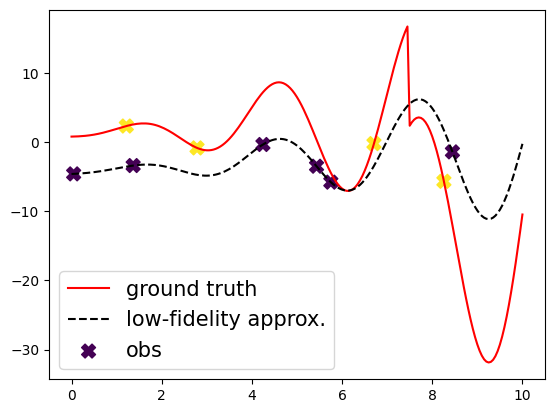

In [ ]:
plt.plot(xs, ys, label="ground truth", c="r")
plt.plot(xs, approx_ys, "k--", label="low-fidelity approx.")

plt.scatter(train_x, train_y, c=train_x_full[:, 1], cmap="viridis", marker="X", label="obs", s=100)

plt.legend(fontsize=15);

In [ ]:
X_test_hf = np.transpose(np.vstack([xs, np.ones_like(xs)*fidelities[0]]))
X_test_lf = np.transpose(np.vstack([xs, np.ones_like(xs)*fidelities[1]]))
X_test =np.vstack((X_test_hf, X_test_lf))
X_test_full = np.vstack((X_test_hf, X_test_lf))
X_test_norm = np.vstack((X_test_hf, X_test_lf))
X_test_norm[:, 0] = (X_test[:, 0]-bounds[0])/(bounds[1]-bounds[0])

Run BO- 15 iterations

Step:1


sample: 100%|██████████| 4000/4000 [00:52<00:00, 75.89it/s, 1023 steps of size 7.99e-05. acc. prob=1.00]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      2.02      0.37      1.97      1.47      2.73      9.42      1.36
         b     12.90      0.70     12.94     11.89     14.00      3.52      1.49
     delta      1.15      0.51      1.07      0.36      1.98      4.81      1.55
  k_length      0.01      0.00      0.01      0.00      0.01     10.38      1.05
   k_scale      7.40      0.76      7.21      6.35      8.78      7.22      1.13
     noise      2.72      1.04      2.56      1.08      4.39      4.36      1.59
         t      7.43      0.44      7.27      6.93      8.19      5.19      1.04



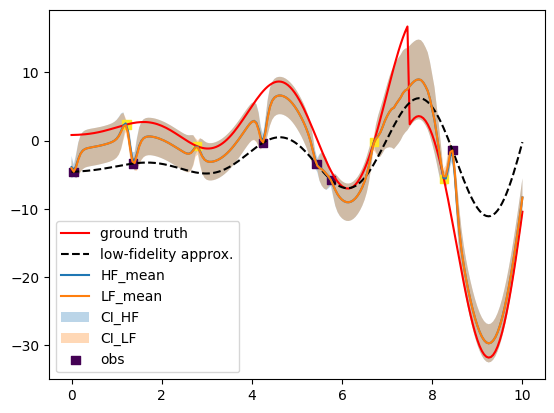

(402,)


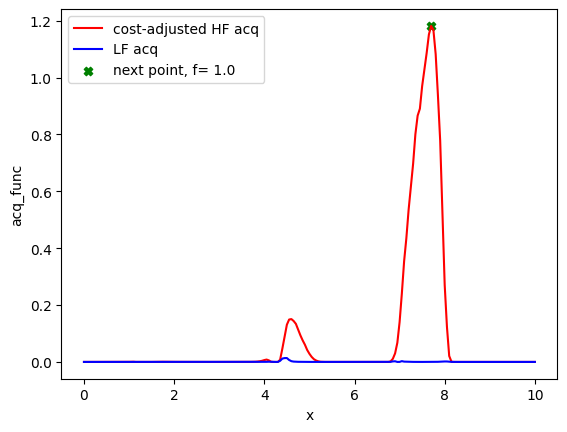

355
Step:2


sample: 100%|██████████| 4000/4000 [01:00<00:00, 65.64it/s, 1023 steps of size 5.65e-04. acc. prob=0.96]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      1.50      0.70      1.51      0.43      2.72     41.92      1.00
         b     13.09      1.02     13.04     11.64     14.89     83.04      1.05
     delta      0.84      0.55      0.74      0.03      1.63    125.78      1.03
  k_length      0.01      0.00      0.01      0.00      0.01    138.32      1.01
   k_scale      7.98      1.62      7.68      5.52     10.37     41.16      1.05
     noise      1.78      3.03      0.99      0.05      3.69     73.23      1.00
         t      7.21      0.29      7.23      6.73      7.62     48.78      1.06

(402,)


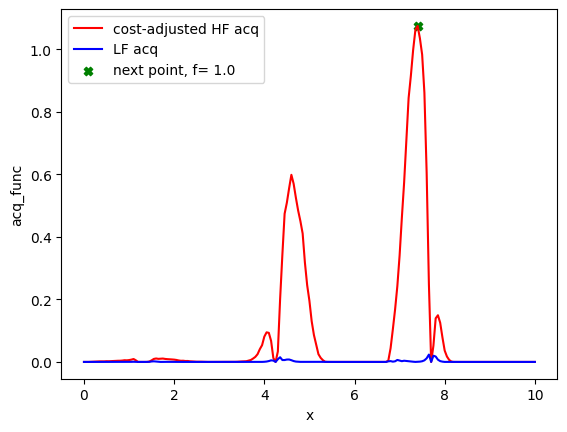

[355 349]
Step:3


sample: 100%|██████████| 4000/4000 [00:36<00:00, 110.07it/s, 1023 steps of size 1.17e-05. acc. prob=1.00]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      1.12      0.04      1.13      1.04      1.18      7.34      1.10
         b     11.55      0.07     11.59     11.45     11.64      2.62      2.70
     delta      0.41      0.00      0.41      0.40      0.41      7.02      1.04
  k_length      0.01      0.00      0.01      0.00      0.01      3.70      1.70
   k_scale      7.25      0.28      7.20      6.89      7.80      6.26      1.25
     noise      0.94      0.02      0.94      0.91      0.98      6.26      1.48
         t      7.67      0.02      7.66      7.65      7.70      5.25      1.00



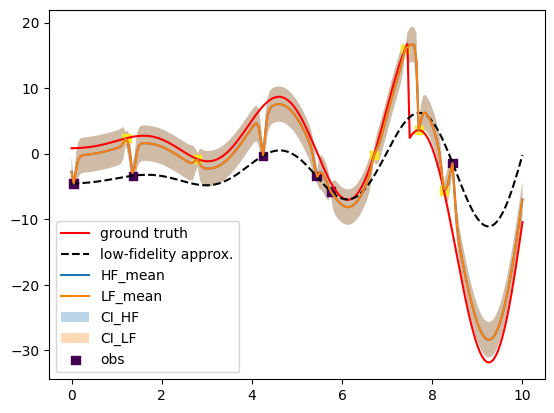

(402,)


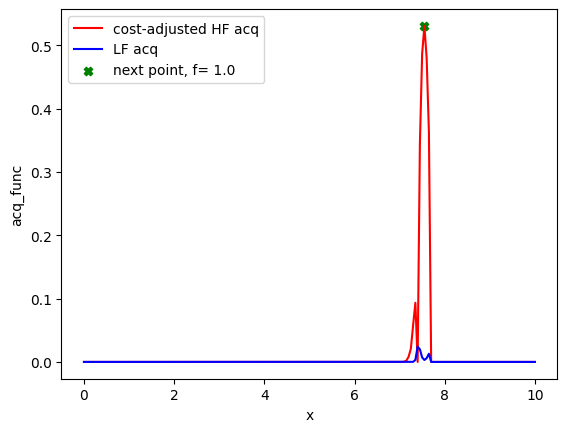

[355 349 352]
Step:4


sample: 100%|██████████| 4000/4000 [01:17<00:00, 51.55it/s, 1023 steps of size 6.19e-05. acc. prob=1.00]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      2.58      0.42      2.65      1.68      3.00      3.60      1.86
         b     13.79      0.52     13.91     13.04     14.51      3.18      1.82
     delta      0.98      0.34      0.96      0.41      1.48      7.63      1.18
  k_length      0.01      0.00      0.01      0.00      0.01      5.93      1.44
   k_scale      7.44      0.60      7.32      6.63      8.56      6.22      1.37
     noise      5.18      1.61      5.12      2.94      8.02      3.68      1.75
         t      7.48      0.03      7.47      7.44      7.54      5.24      1.00

(402,)


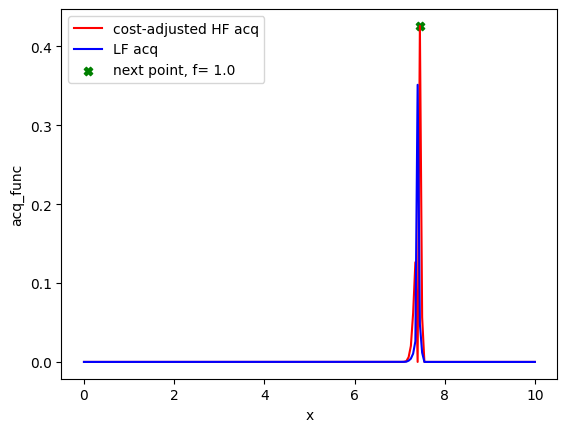

[355 349 352 350]
Step:5


sample: 100%|██████████| 4000/4000 [00:07<00:00, 514.46it/s, 1 steps of size 5.68e-06. acc. prob=0.43] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      3.06      0.01      3.07      3.05      3.08      2.74      2.22
         b     11.83      0.01     11.83     11.82     11.85      2.75      2.21
     delta      0.50      0.00      0.50      0.50      0.50      6.40      1.29
  k_length      0.43      0.01      0.42      0.41      0.45      2.59      2.46
   k_scale      1.87      0.00      1.87      1.87      1.87      5.49      1.35
     noise      1.14      0.00      1.14      1.14      1.14      3.90      1.49
         t      7.87      0.00      7.87      7.87      7.87      2.70      2.29

(402,)


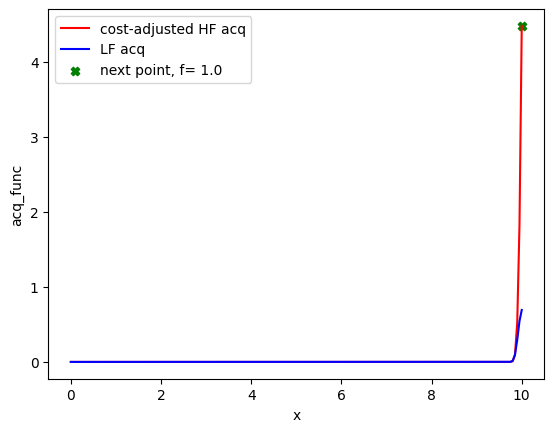

[355 349 352 350 401]
Step:6


sample: 100%|██████████| 4000/4000 [01:34<00:00, 42.53it/s, 1023 steps of size 1.18e-05. acc. prob=1.00]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      2.81      0.04      2.81      2.74      2.88     10.47      1.03
         b     14.75      0.10     14.79     14.61     14.87      2.81      2.40
     delta      0.47      0.03      0.48      0.42      0.52      7.51      1.00
  k_length      0.00      0.00      0.00      0.00      0.00      3.81      1.67
   k_scale      6.49      0.10      6.47      6.37      6.68      6.45      1.20
     noise      3.64      0.17      3.63      3.39      3.94     11.61      1.23
         t      7.54      0.00      7.54      7.54      7.55      5.24      1.00



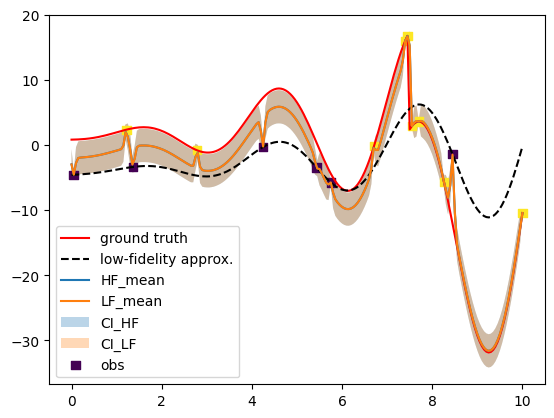

(402,)


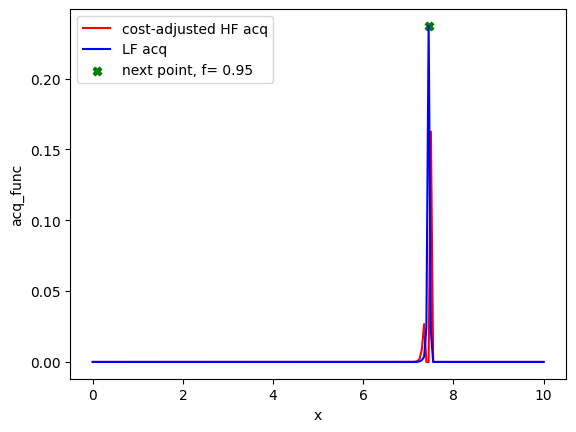

[355 349 352 350 401 149]
Step:7


sample: 100%|██████████| 4000/4000 [00:07<00:00, 532.28it/s, 1 steps of size 3.44e-05. acc. prob=0.68] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.09      0.00      0.09      0.09      0.09      2.53      2.56
         b     14.69      0.00     14.69     14.69     14.69      2.49      2.70
     delta      0.51      0.00      0.51      0.51      0.51      2.58      2.53
  k_length      0.69      0.02      0.69      0.66      0.71      2.50      2.68
   k_scale      1.97      0.00      1.97      1.97      1.97      2.54      2.60
     noise      1.14      0.00      1.14      1.14      1.14      2.88      2.08
         t      7.87      0.00      7.87      7.87      7.87      3.36      1.74

(402,)


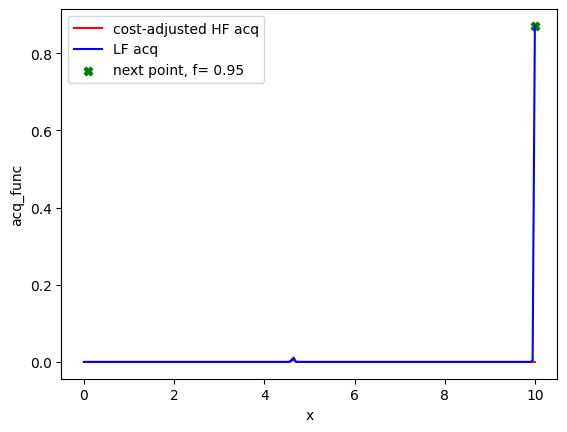

[355 349 352 350 401 149 200]
Step:8


sample: 100%|██████████| 4000/4000 [00:06<00:00, 581.14it/s, 1 steps of size 3.40e-05. acc. prob=0.57] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      2.95      0.13      2.98      2.75      3.12      2.64      2.38
         b     11.89      0.12     11.87     11.73     12.08      2.64      2.38
     delta      0.50      0.00      0.50      0.50      0.50      2.67      2.32
  k_length      0.70      0.03      0.69      0.66      0.74      2.57      2.50
   k_scale      1.88      0.00      1.88      1.88      1.88      2.60      2.47
     noise      1.14      0.00      1.14      1.14      1.14      3.09      1.87
         t      7.87      0.00      7.87      7.87      7.87      2.87      1.98

(402,)


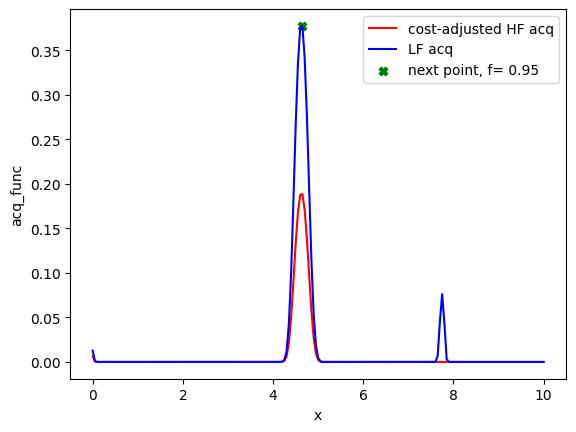

[355 349 352 350 401 149 200  93]
Step:9


sample: 100%|██████████| 4000/4000 [01:20<00:00, 49.66it/s, 1023 steps of size 6.59e-05. acc. prob=0.98]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      1.25      0.31      1.23      0.79      1.76      8.17      1.14
         b     15.16      1.07     15.69     13.29     16.32      2.70      2.12
     delta      4.71      0.25      4.74      4.18      5.01      4.22      1.56
  k_length      0.02      0.01      0.02      0.01      0.03      3.47      1.84
   k_scale     14.78      0.72     14.64     13.77     16.05      5.40      1.53
     noise      1.48      0.28      1.46      1.04      1.96     24.93      1.00
         t      7.50      0.03      7.50      7.46      7.55     12.14      1.22



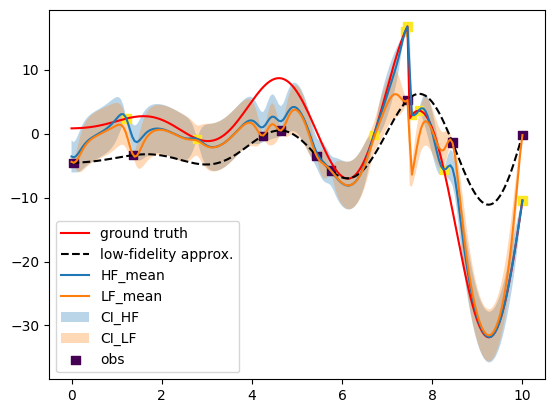

(402,)


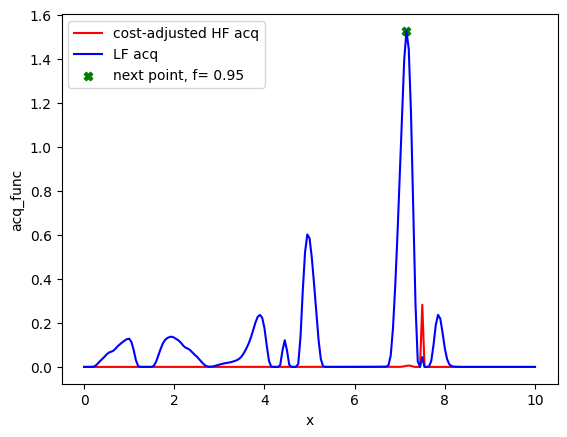

[355 349 352 350 401 149 200  93 143]
Step:10


sample: 100%|██████████| 4000/4000 [01:34<00:00, 42.35it/s, 1023 steps of size 4.91e-06. acc. prob=1.00]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      2.83      0.02      2.83      2.79      2.86      9.59      1.02
         b     13.49      0.07     13.52     13.39     13.57      2.67      2.61
     delta      4.02      0.01      4.02      3.99      4.04      7.17      1.02
  k_length      0.00      0.00      0.00      0.00      0.00      4.15      1.59
   k_scale     13.36      0.05     13.35     13.29     13.45      6.17      1.25
     noise      6.67      0.12      6.66      6.48      6.87      8.92      1.34
         t      7.53      0.01      7.52      7.52      7.55      5.25      1.00

(402,)


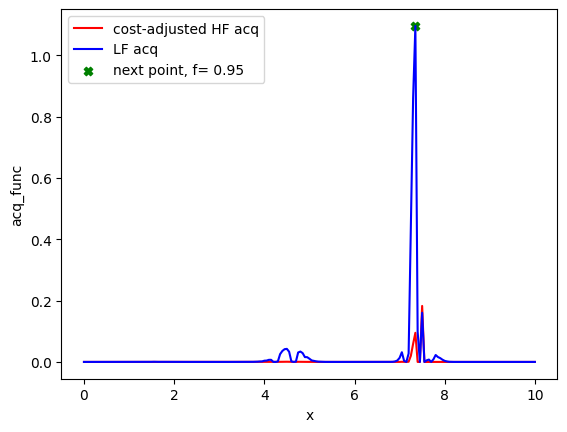

[355 349 352 350 401 149 200  93 143 147]
Step:11


sample: 100%|██████████| 4000/4000 [00:25<00:00, 154.16it/s, 7 steps of size 6.16e-02. acc. prob=0.83]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.91      0.82      0.89     -0.42      2.22    339.28      1.00
         b     15.15      1.09     15.27     13.66     17.02    223.16      1.00
     delta      4.44      0.60      4.41      3.38      5.34    335.18      1.00
  k_length      0.02      0.01      0.02      0.01      0.04    140.19      1.00
   k_scale     15.33      1.75     15.25     12.39     18.02    534.17      1.00
     noise      1.59      2.04      1.01      0.06      3.40    385.67      1.01
         t      7.50      0.03      7.50      7.46      7.55    175.98      1.03

(402,)


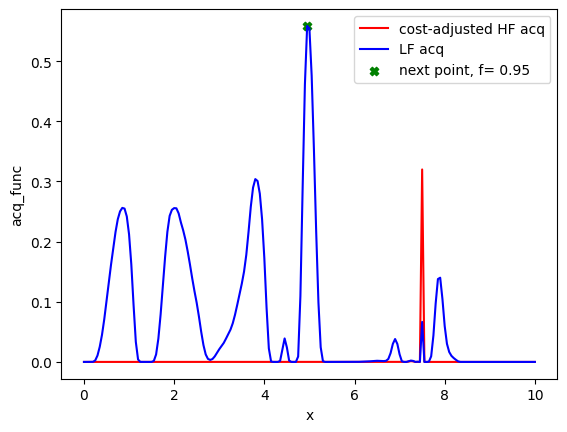

[355 349 352 350 401 149 200  93 143 147  99]
Step:12


sample: 100%|██████████| 4000/4000 [00:18<00:00, 220.04it/s, 29 steps of size 5.94e-02. acc. prob=0.59]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.91      0.80      0.92     -0.37      1.93     31.29      1.07
         b     15.61      0.93     15.55     14.32     16.91     21.51      1.10
     delta      4.55      0.62      4.61      3.56      5.47     94.22      1.06
  k_length      0.03      0.01      0.03      0.02      0.05     14.62      1.04
   k_scale     16.30      2.15     16.31     13.24     19.67     19.30      1.02
     noise      1.40      1.69      1.04      0.06      2.84    256.45      1.00
         t      7.51      0.03      7.50      7.46      7.55     29.17      1.09



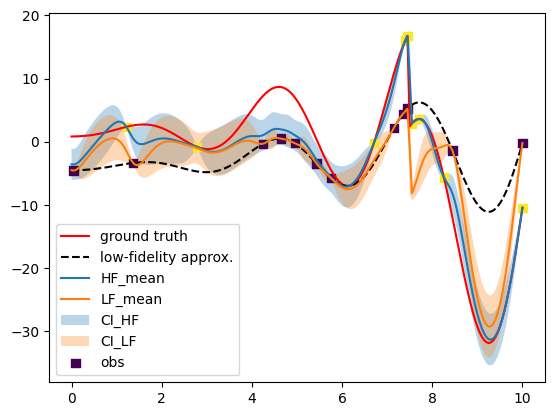

(402,)


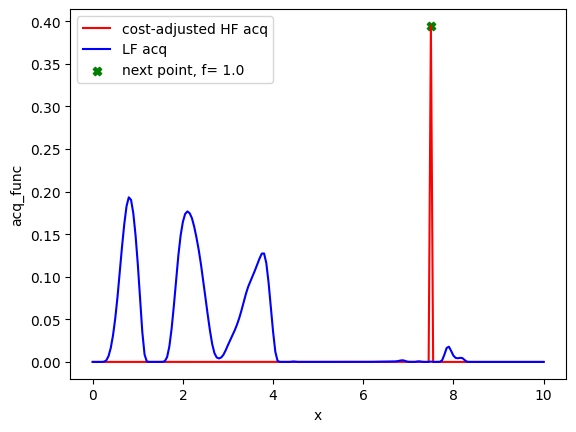

[355 349 352 350 401 149 200  93 143 147  99 351]
Step:13


sample: 100%|██████████| 4000/4000 [01:28<00:00, 45.35it/s, 357 steps of size 2.85e-03. acc. prob=0.96]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.56      0.74      0.52     -0.65      1.71    257.04      1.02
         b     15.56      0.74     15.51     14.35     16.72    257.22      1.02
     delta      4.68      0.62      4.66      3.69      5.69    489.79      1.00
  k_length      0.04      0.01      0.04      0.03      0.05    294.38      1.00
   k_scale     15.89      1.82     15.78     12.91     18.91    432.34      1.00
     noise      1.70      1.93      1.10      0.06      3.98    550.61      1.00
         t      7.47      0.01      7.47      7.45      7.49    264.15      1.00

(402,)


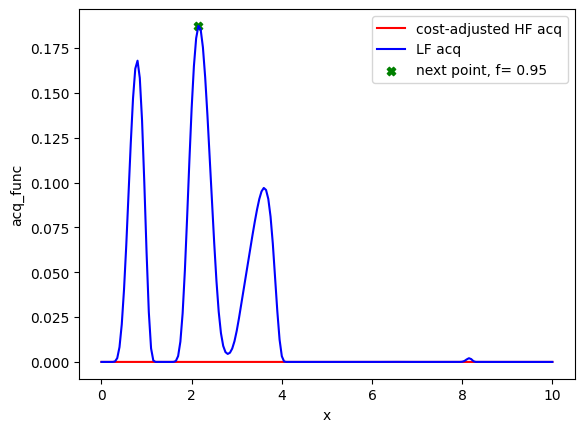

[355 349 352 350 401 149 200  93 143 147  99 351  43]
Step:14


sample: 100%|██████████| 4000/4000 [01:23<00:00, 47.98it/s, 321 steps of size 3.11e-03. acc. prob=0.94] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.64      0.78      0.64     -0.51      1.96    203.75      1.01
         b     15.64      0.77     15.64     14.41     16.87    203.39      1.01
     delta      4.74      0.63      4.70      3.83      5.88    400.05      1.00
  k_length      0.04      0.01      0.04      0.03      0.05    285.63      1.00
   k_scale     15.84      1.79     15.77     12.91     18.78    415.48      1.00
     noise      1.60      1.81      0.99      0.03      3.68    517.69      1.00
         t      7.48      0.01      7.48      7.46      7.50    198.03      1.00

(402,)


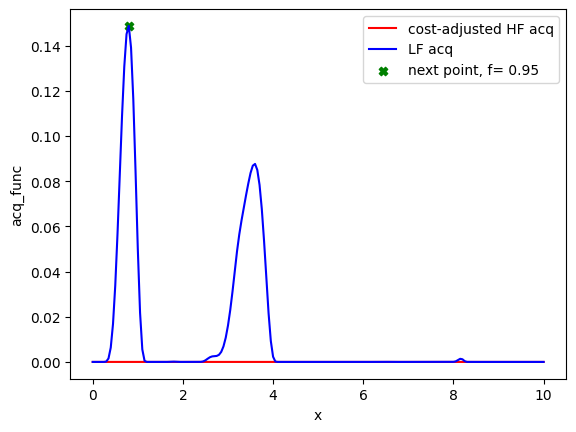

[355 349 352 350 401 149 200  93 143 147  99 351  43  16]
Step:15


sample: 100%|██████████| 4000/4000 [01:25<00:00, 46.76it/s, 1023 steps of size 3.53e-03. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.69      0.73      0.69     -0.42      1.98    294.27      1.00
         b     15.68      0.73     15.68     14.62     17.02    295.82      1.00
     delta      4.79      0.62      4.76      3.71      5.71    519.82      1.00
  k_length      0.04      0.01      0.04      0.03      0.05    511.25      1.00
   k_scale     15.90      1.72     15.79     13.17     18.80    487.23      1.00
     noise      1.56      2.19      0.94      0.05      3.32    253.98      1.01
         t      7.47      0.01      7.47      7.45      7.50    212.30      1.00



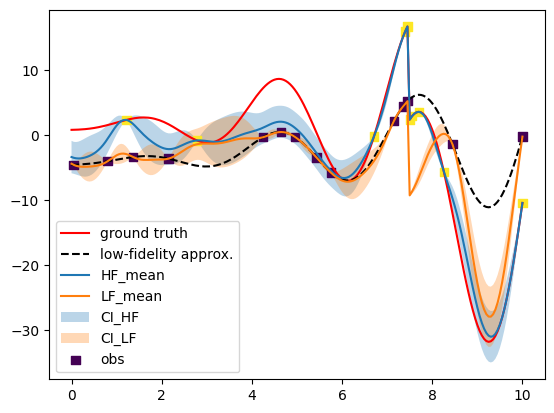

(402,)


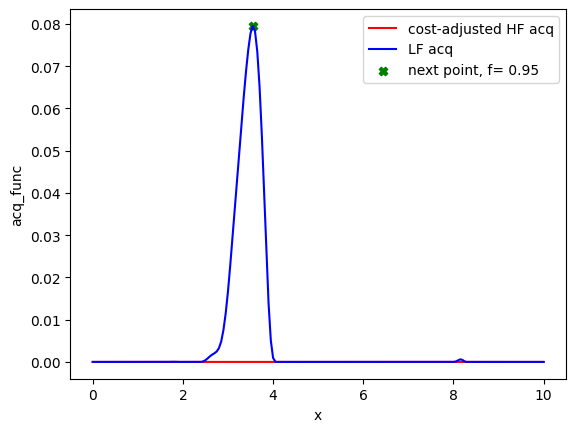

[355 349 352 350 401 149 200  93 143 147  99 351  43  16  71]


In [ ]:
N = 15
cost_ratio = 2
f = np.array([1.0, 2.0])
# Get random number generator keys for training and prediction
rng_key, rng_key_predict = gpax.utils.get_keys()
idx = []
for i in range(1, N+1):
    print("Step:"+str(i))

    # Multi-fidelity structured GP
    gp_model = gpax.ExactGP(1, kernel= fidelity_kernel, kernel_prior = fidelity_kernel_prior, mean_fn=mean_func, mean_fn_prior=mf_priors)
    # Run MCMC to obtain posterior samples
    gp_model.fit(rng_key, train_x_full_norm, train_y, num_chains=1)


    if ((i == 1) or ((i % 3) == 0)): # Check predictions after every 5 BO runs
        y_pred, y_sampled = gp_model.predict(rng_key_predict, X_test_norm[X_test_lf.shape[0]:, :], n=200)
        y_pred_lf, y_sampled_lf = gp_model.predict(rng_key_predict, X_test_norm[0:X_test_lf.shape[0], :], n=200)
        plt.plot(xs, ys, label="ground truth", c="r")
        plt.plot(xs, approx_ys, "k--", label="low-fidelity approx.")
        pred_lower = y_pred - y_sampled.std(axis=(0,1))
        pred_upper = y_pred + y_sampled.std(axis=(0,1))
        pred_lower_lf = y_pred_lf - y_sampled_lf.std(axis=(0,1))
        pred_upper_lf = y_pred_lf + y_sampled_lf.std(axis=(0,1))
        plt.plot(xs, y_pred, label="HF_mean")
        plt.plot(xs, y_pred_lf, label="LF_mean")
        plt.fill_between(
            xs.flatten(),
            pred_lower,
            pred_upper,
            alpha=0.3,
            label="CI_HF",
        )

        plt.fill_between(
            xs.flatten(),
            pred_lower_lf,
            pred_upper_lf,
            alpha=0.3,
            label="CI_LF",
        )

        plt.scatter(train_x_full[:, 0], train_y, c=train_x_full[:, 1], cmap="viridis", marker="s", label="obs")

        plt.legend(loc="best")
        plt.show()
    # Compute the MF acq function - EI based
    test_data = [X_test, X_test_norm]
    acq, next_point_idx, next_point_val  = fidelity_acqfun(gp_model, test_data, f, cost_ratio, rng_key_predict, idx, isnorm=True)
    idx = np.hstack((idx, next_point_idx))
    if i == 1:
        idx = int(idx)
        print(idx)
    else:
        idx = idx
        print(idx)

    # acq = gpax.acquisition.EI(rng_key_predict, gp_model, X_test, maximize=True, noiseless=True)
    # acq = gpax.acquisition.UCB(rng_key_predict, gp_model, X_test, beta=4, maximize=True, noiseless=True)
    if next_point_val == 0:
        print("Model sufficiently learned")
        break
    else:
        next_point = X_test[next_point_idx]
        next_point_norm = X_test_norm[next_point_idx]
        train_x_full = np.vstack((train_x_full, next_point))
        train_x_full_norm = np.vstack((train_x_full_norm, next_point_norm))
        #print(next_point_idx, next_point, next_point_norm, train_x_full, train_x_full_norm)

        train_y = evaluate_all_functions(train_x_full)

    #X_test = np.concatenate([X_test[:next_point_idx], X_test[next_point_idx+1:]])
    #print(X_test.shape)

In [ ]:
train_x_full

array([[ 5.43404942,  0.95      ],
       [ 2.78369385,  1.        ],
       [ 4.24517591,  0.95      ],
       [ 8.44776132,  0.95      ],
       [ 0.04718856,  0.95      ],
       [ 1.21569121,  1.        ],
       [ 6.70749085,  1.        ],
       [ 8.25852755,  1.        ],
       [ 1.3670659 ,  0.95      ],
       [ 5.75093329,  0.95      ],
       [ 7.7       ,  1.        ],
       [ 7.4       ,  1.        ],
       [ 7.55      ,  1.        ],
       [ 7.45      ,  1.        ],
       [10.        ,  1.        ],
       [ 7.45      ,  0.95      ],
       [10.        ,  0.95      ],
       [ 4.65      ,  0.95      ],
       [ 7.15      ,  0.95      ],
       [ 7.35      ,  0.95      ],
       [ 4.95      ,  0.95      ],
       [ 7.5       ,  1.        ],
       [ 2.15      ,  0.95      ],
       [ 0.8       ,  0.95      ],
       [ 3.55      ,  0.95      ]])

# Defining prioir mean function of GP with hyperprior learnable parameters

- Lets provide partially correct information

In [ ]:
@jit
def mean_func2(x: jnp.ndarray, params: Dict[str, float]) -> jnp.ndarray:

    x_data = x[:,0]
    #jax.debug.print("x_norm: {}", x_data)
    lb = 0
    ub = 10
    x_data = x_data*(ub-lb) + lb
    #jax.debug.print("x: {}", x_data)

    return jnp.piecewise(
            x_data, [x_data < params["t"], x_data >= params["t"]],
            [lambda x_data: (x_data**2) - params["a"],
             lambda x_data: (x_data**2) - params["b"]])


def mf2_priors():
    # Sample model parameters
    t = numpyro.sample("t", numpyro.distributions.Uniform(5.0, 10.0))
    a = numpyro.sample("a", numpyro.distributions.Normal(0, 1))
    b = numpyro.sample("b", numpyro.distributions.Normal(15, 2))

    # Return sampled parameters as a dictionary
    return {"t": t, "a": a, "b": b}

In [ ]:
n = 10

np.random.seed(100)
train_x = bounds[0] + (bounds[1] - bounds[0]) * np.random.rand(n, 1)
train_x_norm = (train_x-bounds[0])/(bounds[1]-bounds[0])
train_f = fidelities[np.random.randint(0, 2, (n, 1))]  # mixed fidelity
#train_f = torch.ones_like(train_x) * fidelities[0]  # only the low fidelity
train_x_full = np.concatenate((train_x, train_f), axis=1)
train_x_full_norm = np.concatenate((train_x_norm, train_f), axis=1)
train_x_full, train_x_full_norm

(array([[5.43404942, 0.95      ],
        [2.78369385, 1.        ],
        [4.24517591, 0.95      ],
        [8.44776132, 0.95      ],
        [0.04718856, 0.95      ],
        [1.21569121, 1.        ],
        [6.70749085, 1.        ],
        [8.25852755, 1.        ],
        [1.3670659 , 0.95      ],
        [5.75093329, 0.95      ]]),
 array([[0.54340494, 0.95      ],
        [0.27836939, 1.        ],
        [0.42451759, 0.95      ],
        [0.84477613, 0.95      ],
        [0.00471886, 0.95      ],
        [0.12156912, 1.        ],
        [0.67074908, 1.        ],
        [0.82585276, 1.        ],
        [0.13670659, 0.95      ],
        [0.57509333, 0.95      ]]))

In [ ]:
train_y = evaluate_all_functions(train_x_full)
train_y

array([[-3.46601045],
       [-0.81858374],
       [-0.32370422],
       [-1.39025485],
       [-4.57530777],
       [ 2.3485763 ],
       [-0.19552183],
       [-5.65119885],
       [-3.37022155],
       [-5.77208799]])

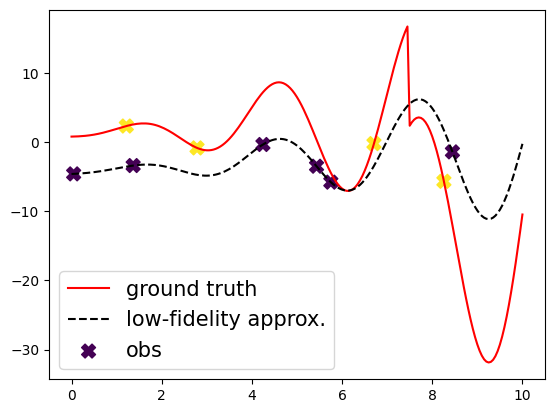

In [ ]:
plt.plot(xs, ys, label="ground truth", c="r")
plt.plot(xs, approx_ys, "k--", label="low-fidelity approx.")

plt.scatter(train_x, train_y, c=train_x_full[:, 1], cmap="viridis", marker="X", label="obs", s=100)

plt.legend(fontsize=15);

In [ ]:
X_test_hf = np.transpose(np.vstack([xs, np.ones_like(xs)*fidelities[0]]))
X_test_lf = np.transpose(np.vstack([xs, np.ones_like(xs)*fidelities[1]]))
X_test =np.vstack((X_test_hf, X_test_lf))
X_test_full = np.vstack((X_test_hf, X_test_lf))
X_test_norm = np.vstack((X_test_hf, X_test_lf))
X_test_norm[:, 0] = (X_test[:, 0]-bounds[0])/(bounds[1]-bounds[0])

Step:1


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:27<00:00, 147.11it/s, 803 steps of size 5.82e-03. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      3.59      0.90      3.57      2.06      4.99    243.67      1.00
         b     18.61      0.90     18.59     17.12     20.04    243.29      1.00
     delta      3.42      0.46      3.40      2.61      4.15    495.87      1.00
  k_length      0.10      0.00      0.10      0.09      0.10    393.55      1.00
   k_scale     39.61      1.73     39.52     36.73     42.46    373.54      1.00
     noise      1.54      1.73      0.99      0.06      3.36    621.85      1.00
         t      7.48      0.01      7.47      7.46      7.50    185.86      1.00



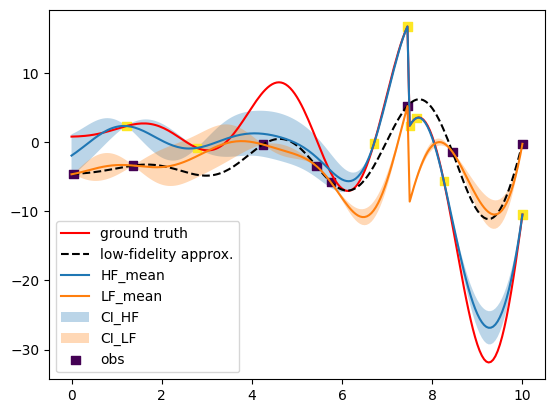

(402,)


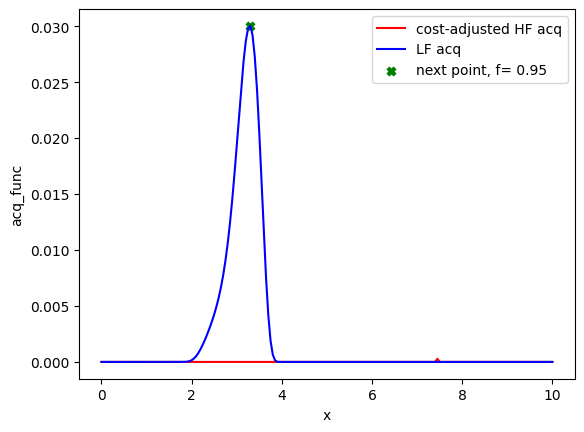

66
Step:2


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample:  77%|███████▋  | 3065/4000 [00:21<00:06, 145.61it/s, 160 steps of size 5.50e-03. acc. prob=0.94]


KeyboardInterrupt: ignored

In [ ]:
N = 12
cost_ratio = 2
f = np.array([1.0, 2.0])
# Get random number generator keys for training and prediction
rng_key, rng_key_predict = gpax.utils.get_keys()
idx = []
for i in range(1, N+1):
    print("Step:"+str(i))

    # Multi-fidelity structured GP
    gp_model = gpax.ExactGP(1, kernel= fidelity_kernel, kernel_prior = fidelity_kernel_prior, mean_fn=mean_func2, mean_fn_prior=mf2_priors)
    # Run MCMC to obtain posterior samples
    gp_model.fit(rng_key, train_x_full_norm, train_y, num_chains=1)


    if ((i == 1) or ((i % 3) == 0)): # Check predictions after every 5 BO runs
        y_pred, y_sampled = gp_model.predict(rng_key_predict, X_test_norm[X_test_lf.shape[0]:, :], n=200)
        y_pred_lf, y_sampled_lf = gp_model.predict(rng_key_predict, X_test_norm[0:X_test_lf.shape[0], :], n=200)
        plt.plot(xs, ys, label="ground truth", c="r")
        plt.plot(xs, approx_ys, "k--", label="low-fidelity approx.")
        pred_lower = y_pred - y_sampled.std(axis=(0,1))
        pred_upper = y_pred + y_sampled.std(axis=(0,1))
        pred_lower_lf = y_pred_lf - y_sampled_lf.std(axis=(0,1))
        pred_upper_lf = y_pred_lf + y_sampled_lf.std(axis=(0,1))
        plt.plot(xs, y_pred, label="HF_mean")
        plt.plot(xs, y_pred_lf, label="LF_mean")
        plt.fill_between(
            xs.flatten(),
            pred_lower,
            pred_upper,
            alpha=0.3,
            label="CI_HF",
        )

        plt.fill_between(
            xs.flatten(),
            pred_lower_lf,
            pred_upper_lf,
            alpha=0.3,
            label="CI_LF",
        )

        plt.scatter(train_x_full[:, 0], train_y, c=train_x_full[:, 1], cmap="viridis", marker="s", label="obs")

        plt.legend(loc="best")
        plt.show()
    # Compute the MF acq function - EI based
    test_data = [X_test, X_test_norm]
    acq, next_point_idx, next_point_val  = fidelity_acqfun(gp_model, test_data, f, cost_ratio, rng_key_predict, idx, isnorm=True)
    idx = np.hstack((idx, next_point_idx))
    if i == 1:
        idx = int(idx)
        print(idx)
    else:
        idx = idx
        print(idx)

    # acq = gpax.acquisition.EI(rng_key_predict, gp_model, X_test, maximize=True, noiseless=True)
    # acq = gpax.acquisition.UCB(rng_key_predict, gp_model, X_test, beta=4, maximize=True, noiseless=True)
    if next_point_val == 0:
        print("Model sufficiently learned")
        break
    else:
        next_point = X_test[next_point_idx]
        next_point_norm = X_test_norm[next_point_idx]
        train_x_full = np.vstack((train_x_full, next_point))
        train_x_full_norm = np.vstack((train_x_full_norm, next_point_norm))
        #print(next_point_idx, next_point, next_point_norm, train_x_full, train_x_full_norm)

        train_y = evaluate_all_functions(train_x_full)

    #X_test = np.concatenate([X_test[:next_point_idx], X_test[next_point_idx+1:]])
    #print(X_test.shape)

- We can see the sMFBO with partially correct knowledge can able to capture the true optimal region at the region of discontinuity earlier than MFBO.

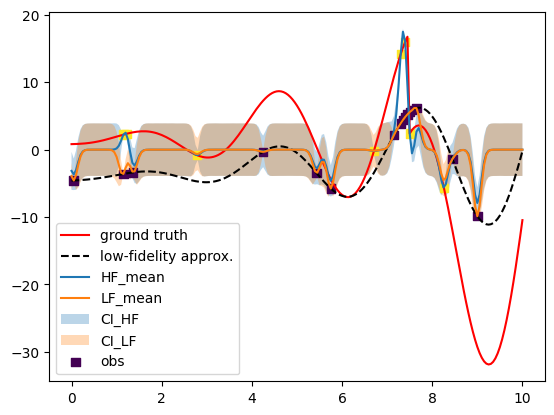


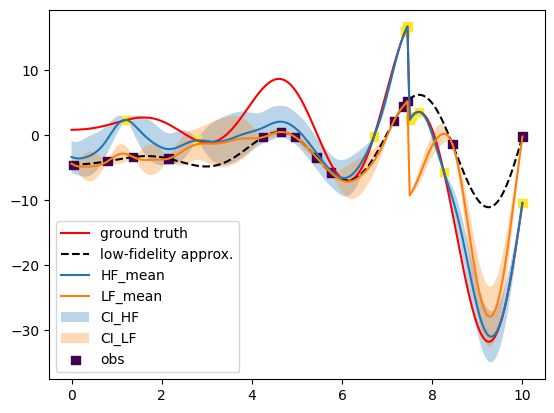

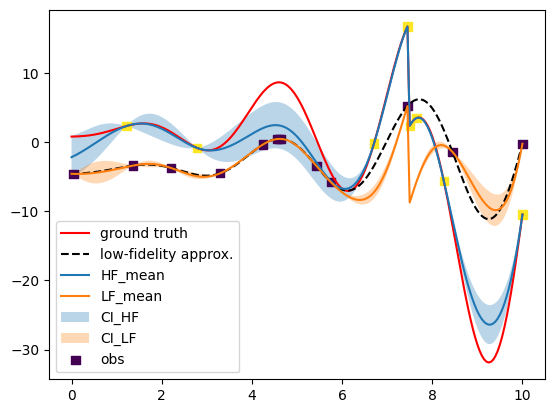

# Interractive MFBO

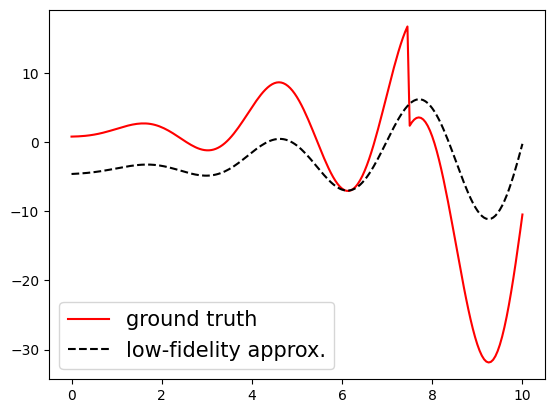

In [ ]:
def dobjective(x):
    # a modification of https://www.sfu.ca/~ssurjano/forretal08.html
    y = np.zeros_like(x)
    for i in range(x.shape[0]):
        if x[i] < 7.5:
            y[i] = -((x[i] + 1) ** 2) * np.sin(2 * x[i] + 2) / 5 + 1 + x[i] / 3
        elif x[i] >=7.5:
            y[i] = -((x[i] + 1) ** 2) * np.sin(2 * x[i] + 2) / 5 + 1 + x[i] / 3 - 15
    return y

def objective(x):
    # a modification of https://www.sfu.ca/~ssurjano/forretal08.html
    y = -((x + 1) ** 2) * np.sin(2 * x + 2) / 5 + 1 + x / 3
    return y

def approx_objective(x):
        return 0.5 * objective(x) + x / 4 -5


def evaluate_all_functions(x_full):
    y = []
    for x in x_full:
        if np.isclose(x[-1], np.ones(1)):
            y.append(dobjective(x[:-1]))
        else:
            y.append(approx_objective(x[:-1]))

    return np.asarray(y)


lb = 0
ub = 10

bounds = np.array((lb, ub), dtype=float)
fidelities = np.array((0.95, 1.0))

xs = np.linspace(lb, ub, 201)

ys = dobjective(xs)
approx_ys = approx_objective(xs)


plt.plot(xs, ys, label="ground truth", c="r")
plt.plot(xs, approx_ys, "k--", label="low-fidelity approx.")

plt.legend(fontsize=15);

In [ ]:
#@title user interraction function

def ipolicy(train_x, train_x_norm, train_y, X_test, X_test_norm, imodel, cost_ratio, N, k, idx):
    # Step 7a
    print("Do you want to update current policy? y- Yes or press ENTER- No")
    ip = str(input("Answer: "))
    if (ip == 'Y' or ip == 'y'):
        print("What policies you want to change? Options: 1-parameter space, 2-surrogate model, 3-acq. func., 4-convergence")
        cp = list(map(int, input("Enter multiple choices each followed by a space: ").split()))
        print("choices made: ", cp)
        for i in cp:
          if i == 1: #Change parameter space
            idx=[]
            print("Provide minimum and maximum values of X")
            lb, ub = input("Enter two values: ").split()
            lb = int(lb)
            ub = int(ub)
            fidelities = np.array((0.95, 1.0))
            xs = np.linspace(lb, ub, 201)
            X_test_lf = np.transpose(np.vstack([xs, np.ones_like(xs)*fidelities[0]]))
            X_test_hf = np.transpose(np.vstack([xs, np.ones_like(xs)*fidelities[1]]))
            X_test =np.vstack((X_test_lf, X_test_hf))
            X_test_full = np.vstack((X_test_lf, X_test_hf))
            X_test_norm = np.vstack((X_test_lf, X_test_hf))
            X_test_norm[:, 0] = (X_test[:, 0]-lb)/(ub-lb)

            #Removing the training data outside the new range
            train_y = train_y[train_x[:,0]<=ub]
            train_x = train_x[train_x[:,0]<=ub]
            train_x_norm = train_x[train_x[:,0]<=ub]
            train_x_norm[:, 0] = (train_x[:,0]-lb)/(ub-lb)


          if i == 2: #Change surrogate model
            print("Provide choice of model: 1-standard 2-structured")
            imodel = int(input("enter choice: "))
          if i == 3: #Change acquisition function
            print("Provide new cost ratio between high and low fidelities")
            cost_ratio = float(input("enter value: "))
          if i == 4: #Change convergence criteria
            print("Provide new number of total iterations.")
            N = int(input("enter value: "))
            if N<=k:
              print("Invalid number. Please provide total iterations greater than current iteration")
              N = int(input("enter value: "))
          if (i > 4) or (i < 1):
              print("Invalid choice")

    return train_x, train_x_norm, train_y, X_test, X_test_norm, imodel, cost_ratio, N, idx

In [ ]:
@jit
def mean_func2(x: jnp.ndarray, params: Dict[str, float]) -> jnp.ndarray:

    x_data = x[:,0]
    #jax.debug.print("x_norm: {}", x_data)
    lb = 0
    ub = 10
    x_data = x_data*(ub-lb) + lb
    #jax.debug.print("x: {}", x_data)

    return jnp.piecewise(
            x_data, [x_data < params["t"], x_data >= params["t"]],
            [lambda x_data: (x_data**2) - params["a"],
             lambda x_data: (x_data**2) - params["b"]])


def mf2_priors():
    # Sample model parameters
    t = numpyro.sample("t", numpyro.distributions.Uniform(5.0, 10.0))
    a = numpyro.sample("a", numpyro.distributions.Normal(0, 1))
    b = numpyro.sample("b", numpyro.distributions.Normal(15, 2))

    # Return sampled parameters as a dictionary
    return {"t": t, "a": a, "b": b}

# Run 10 evaluations randomly

In [ ]:
n = 10

np.random.seed(100)
train_x = bounds[0] + (bounds[1] - bounds[0]) * np.random.rand(n, 1)
train_x_norm = (train_x-bounds[0])/(bounds[1]-bounds[0])
train_f = fidelities[np.random.randint(0, 2, (n, 1))]  # mixed fidelity
#train_f = torch.ones_like(train_x) * fidelities[0]  # only the low fidelity
train_x_full = np.concatenate((train_x, train_f), axis=1)
train_x_full_norm = np.concatenate((train_x_norm, train_f), axis=1)
train_x_full, train_x_full_norm

(array([[5.43404942, 0.95      ],
        [2.78369385, 1.        ],
        [4.24517591, 0.95      ],
        [8.44776132, 0.95      ],
        [0.04718856, 0.95      ],
        [1.21569121, 1.        ],
        [6.70749085, 1.        ],
        [8.25852755, 1.        ],
        [1.3670659 , 0.95      ],
        [5.75093329, 0.95      ]]),
 array([[0.54340494, 0.95      ],
        [0.27836939, 1.        ],
        [0.42451759, 0.95      ],
        [0.84477613, 0.95      ],
        [0.00471886, 0.95      ],
        [0.12156912, 1.        ],
        [0.67074908, 1.        ],
        [0.82585276, 1.        ],
        [0.13670659, 0.95      ],
        [0.57509333, 0.95      ]]))

In [ ]:
train_y = evaluate_all_functions(train_x_full)
train_y

array([[-3.46601045],
       [-0.81858374],
       [-0.32370422],
       [-1.39025485],
       [-4.57530777],
       [ 2.3485763 ],
       [-0.19552183],
       [-5.65119885],
       [-3.37022155],
       [-5.77208799]])

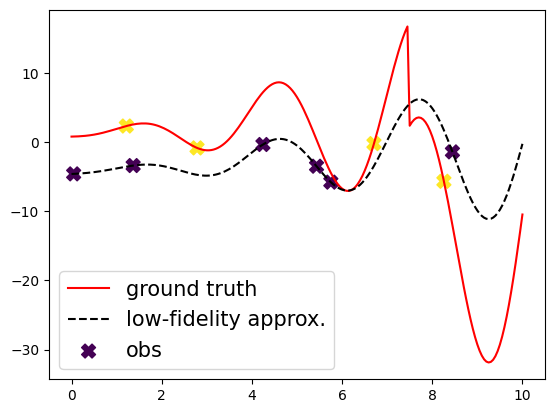

In [ ]:
plt.plot(xs, ys, label="ground truth", c="r")
plt.plot(xs, approx_ys, "k--", label="low-fidelity approx.")

plt.scatter(train_x, train_y, c=train_x_full[:, 1], cmap="viridis", marker="X", label="obs", s=100)

plt.legend(fontsize=15);

In [ ]:
X_test_lf = np.transpose(np.vstack([xs, np.ones_like(xs)*fidelities[0]]))
X_test_hf = np.transpose(np.vstack([xs, np.ones_like(xs)*fidelities[1]]))
X_test =np.vstack((X_test_lf, X_test_hf))
X_test_full = np.vstack((X_test_lf, X_test_hf))
X_test_norm = np.vstack((X_test_lf, X_test_hf))
X_test_norm[:, 0] = (X_test[:, 0]-bounds[0])/(bounds[1]-bounds[0])

Step:1


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:42<00:00, 93.37it/s, 1023 steps of size 1.16e-04. acc. prob=0.99]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      1.52      0.74      1.46     -0.08      2.28      7.67      1.46
         b     23.05      0.95     22.92     21.55     24.50      4.63      1.23
     delta      2.76      0.35      2.75      2.22      3.43      4.86      1.56
  k_length      0.17      0.01      0.17      0.16      0.19      8.15      1.11
   k_scale     26.31      1.30     26.21     24.29     28.28      4.84      1.84
     noise      2.23      1.22      1.87      0.48      4.07      4.66      1.47
         t      7.44      0.50      7.34      6.74      8.19      5.03      1.26



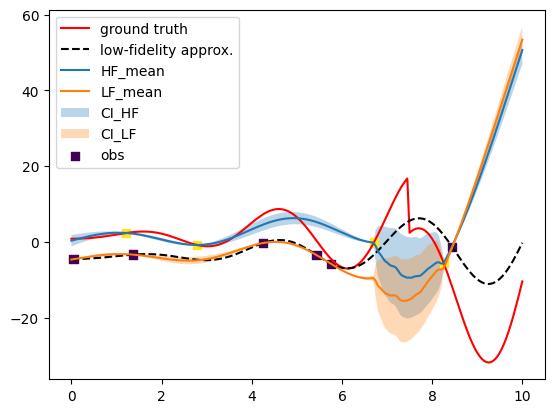

(402,)


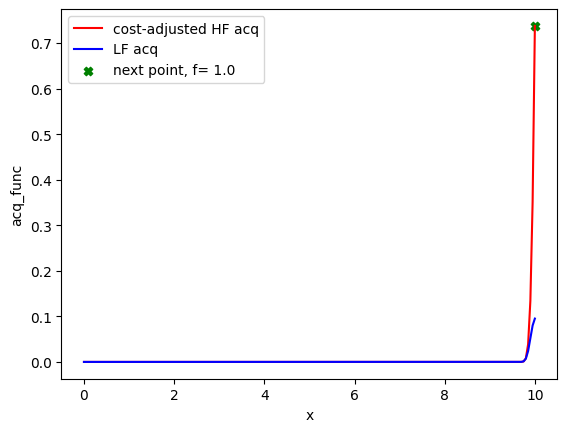

401
Step:2


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:38<00:00, 104.21it/s, 1023 steps of size 6.77e-03. acc. prob=0.73]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      1.49      0.98      1.51     -0.08      3.17   1066.29      1.00
         b     24.74      1.86     24.71     21.85     27.93    686.28      1.00
     delta      1.88      0.48      1.84      1.10      2.59   1040.57      1.00
  k_length      0.13      0.01      0.13      0.12      0.14    975.01      1.00
   k_scale     35.00      1.74     34.99     32.10     37.86   1138.91      1.00
     noise      1.59      2.21      1.02      0.04      3.22    991.51      1.00
         t      7.45      0.44      7.44      6.72      8.09    703.63      1.00



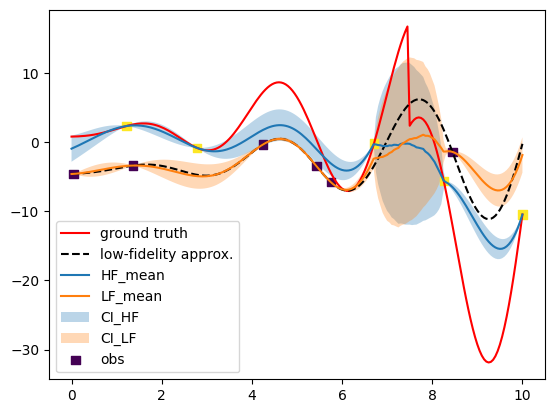

(402,)


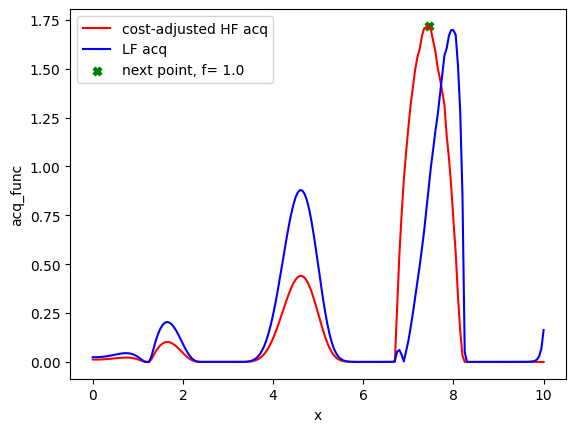

[401 350]
Step:3


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:14<00:00, 275.25it/s, 63 steps of size 3.90e-02. acc. prob=0.74]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.70      0.97      0.70     -0.96      2.21    971.39      1.00
         b     28.32      1.71     28.32     25.61     31.06    726.49      1.00
     delta      1.83      0.47      1.79      1.09      2.58    851.83      1.00
  k_length      0.12      0.01      0.12      0.11      0.13    816.63      1.00
   k_scale     34.50      1.82     34.43     31.83     37.80    749.19      1.00
     noise      1.58      2.02      0.96      0.08      3.48    971.77      1.00
         t      7.84      0.23      7.84      7.45      8.17    478.77      1.00



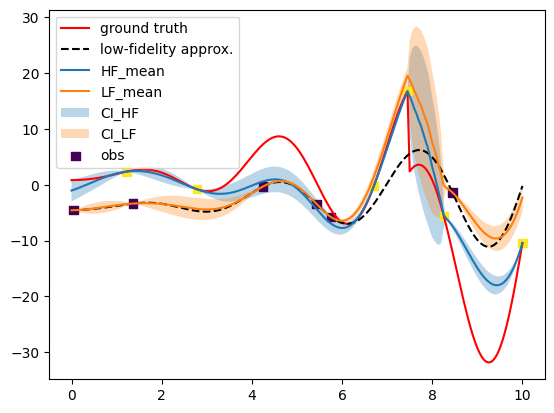

(402,)


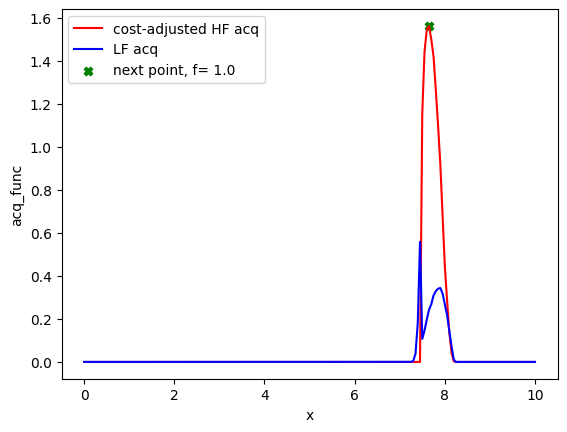

[401 350 354]
Step:4


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:09<00:00, 401.20it/s, 4 steps of size 1.44e-01. acc. prob=0.83] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      3.36      0.88      3.33      2.07      4.89    444.29      1.00
         b     17.74      0.89     17.72     16.39     19.27    436.70      1.00
     delta      2.11      0.45      2.07      1.42      2.85    666.31      1.00
  k_length      0.11      0.00      0.11      0.10      0.12    471.81      1.00
   k_scale     37.82      1.75     37.75     35.02     40.87    568.99      1.00
     noise      1.52      2.06      0.94      0.05      3.21    816.46      1.00
         t      7.55      0.06      7.55      7.47      7.64    205.51      1.03



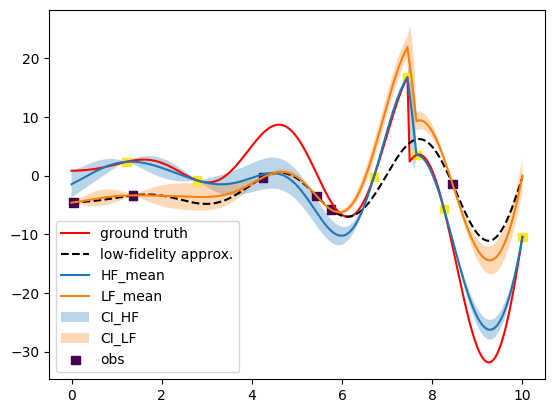

(402,)


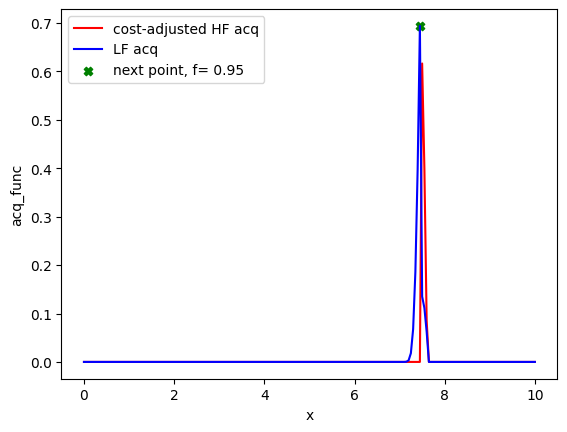

[401 350 354 149]
Step:5


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:08<00:00, 448.80it/s, 1 steps of size 1.65e-01. acc. prob=0.83] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      3.54      0.88      3.51      2.03      4.99    470.17      1.00
         b     17.96      0.90     17.92     16.33     19.36    472.66      1.00
     delta      4.15      0.56      4.13      3.23      5.05    557.37      1.00
  k_length      0.10      0.01      0.10      0.09      0.11    625.58      1.00
   k_scale     39.01      1.70     38.97     36.03     41.70    638.79      1.01
     noise      1.57      1.84      1.00      0.03      3.47    701.72      1.00
         t      7.55      0.06      7.55      7.47      7.65    221.54      1.02



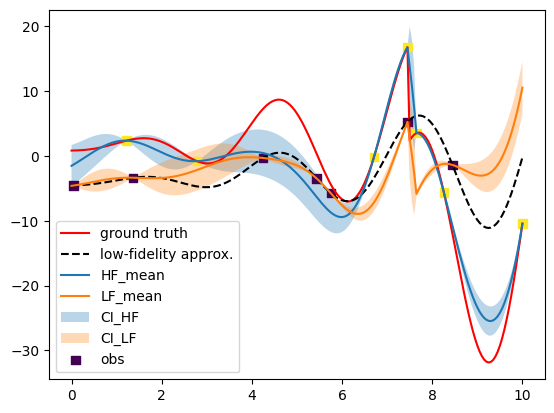

(402,)


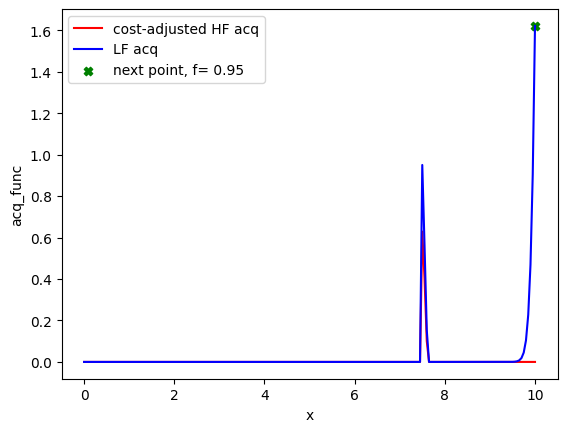

[401 350 354 149 200]
Step:6


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:10<00:00, 374.76it/s, 1 steps of size 7.66e-02. acc. prob=0.89] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      3.71      0.88      3.70      2.17      5.01    416.74      1.00
         b     18.11      0.91     18.09     16.52     19.51    435.75      1.00
     delta      3.44      0.48      3.42      2.62      4.15    587.69      1.00
  k_length      0.10      0.00      0.10      0.09      0.10    542.95      1.00
   k_scale     39.41      1.78     39.43     36.28     42.29    521.59      1.00
     noise      1.57      2.05      0.97      0.06      3.50    414.68      1.02
         t      7.55      0.06      7.55      7.46      7.64    297.22      1.01



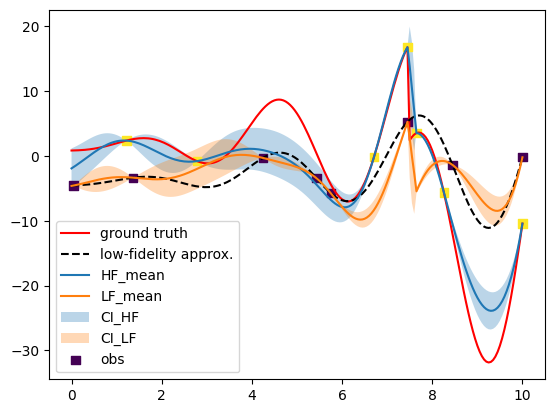

(402,)


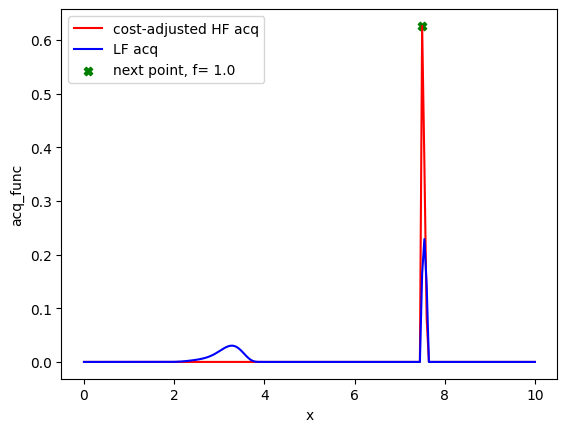

[401 350 354 149 200 351]
User interraction for policy change
Do you want to update current policy? y- Yes or press ENTER- No
What policies you want to change? Options: 1-parameter space, 2-surrogate model, 3-acq. func., 4-convergence
choices made:  [1, 2, 3]
Provide minimum and maximum values of X
Provide choice of model: 1-standard 2-structured
Provide new cost ratio between high and low fidelities
Step:7


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:04<00:00, 248.57it/s, 7 steps of size 3.99e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      0.77      0.62      0.63      0.00      1.68    323.34      1.00
  k_length      0.01      0.01      0.01      0.00      0.03    423.06      1.00
   k_scale      6.51      1.60      6.42      3.99      9.15    400.86      1.00
     noise      1.46      1.79      0.81      0.03      3.23    230.31      1.00



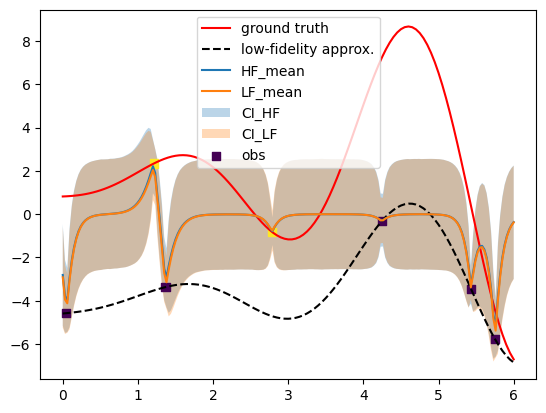

(402,)


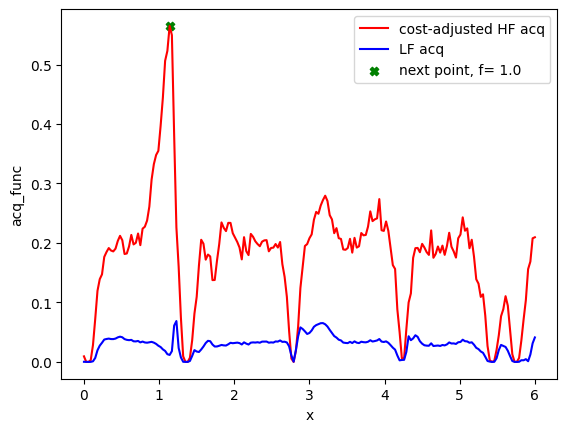

239
Step:8


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:04<00:00, 244.65it/s, 3 steps of size 4.92e-01. acc. prob=0.87]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      0.82      0.64      0.70      0.01      1.77    450.59      1.00
  k_length      0.01      0.01      0.01      0.00      0.02    157.18      1.00
   k_scale      6.36      1.62      6.24      3.51      8.62    452.97      1.00
     noise      1.65      2.10      0.99      0.07      3.78    304.83      1.00



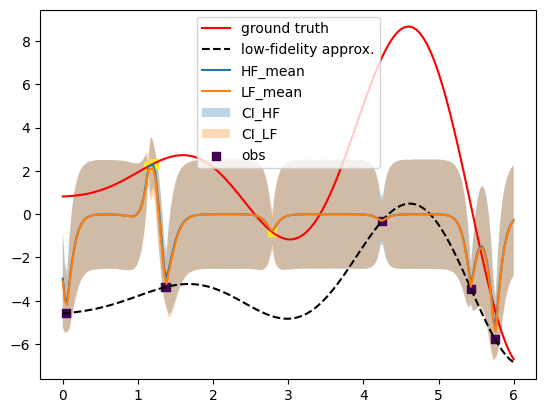

(402,)


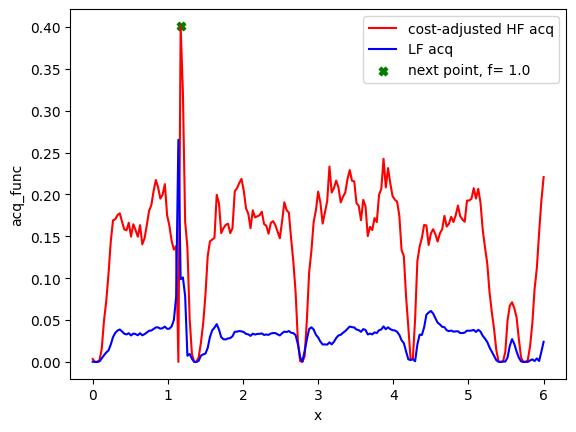

[239 240]
Step:9


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:04<00:00, 245.53it/s, 7 steps of size 3.61e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      0.87      0.62      0.74      0.00      1.77    279.56      1.00
  k_length      0.01      0.00      0.01      0.01      0.02    183.38      1.01
   k_scale      6.36      1.46      6.27      3.89      8.63    314.04      1.00
     noise      1.41      1.63      0.90      0.03      3.01    292.02      1.00



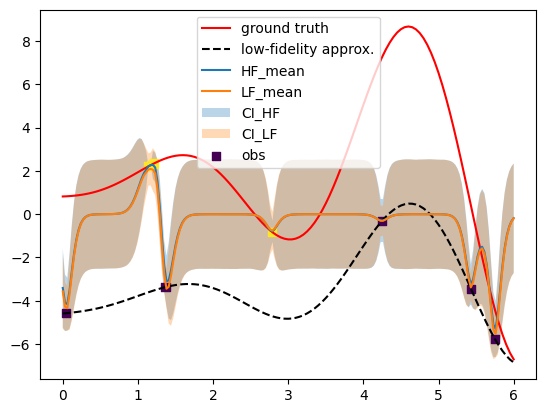

(402,)


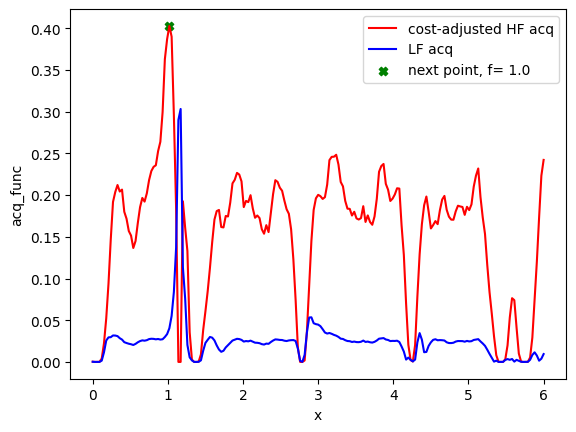

[239 240 235]
Step:10


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:04<00:00, 246.92it/s, 7 steps of size 5.01e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      2.75      0.56      2.71      1.77      3.60    343.34      1.00
  k_length      0.14      0.04      0.15      0.08      0.20    296.88      1.01
   k_scale      9.42      1.74      9.32      6.62     12.38    497.28      1.00
     noise      1.56      1.77      0.94      0.08      3.37    260.12      1.00



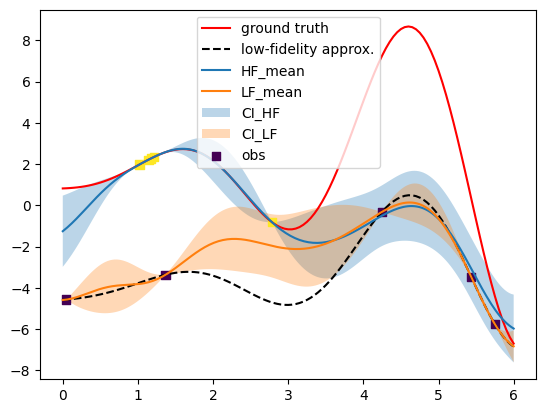

(402,)


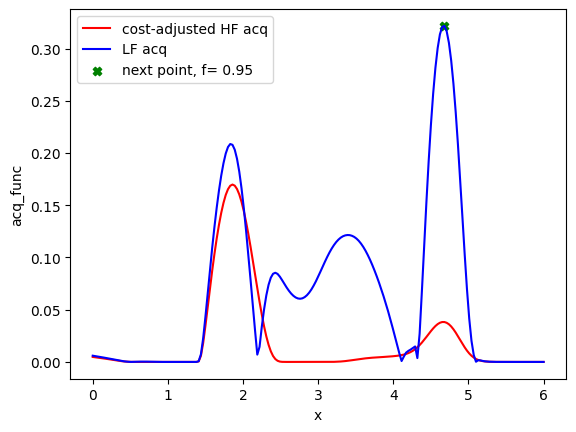

[239 240 235 156]
Step:11


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:04<00:00, 243.13it/s, 7 steps of size 3.91e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      2.79      0.59      2.75      1.80      3.76    366.11      1.00
  k_length      0.15      0.03      0.15      0.12      0.19    209.35      1.00
   k_scale      9.53      1.81      9.44      6.56     12.33    502.22      1.00
     noise      1.64      1.98      1.02      0.06      3.66    292.79      1.00



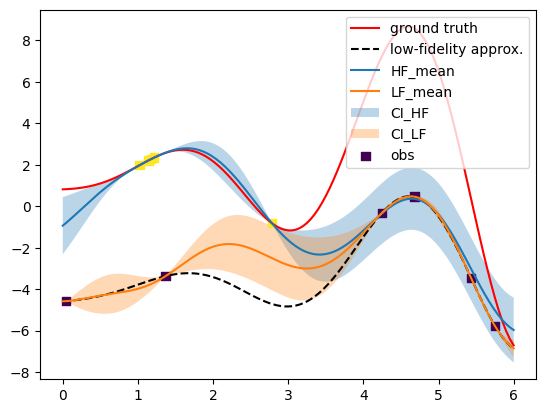

(402,)


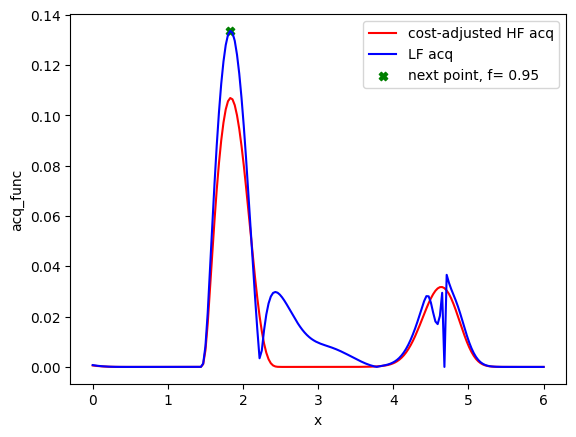

[239 240 235 156  61]
Step:12


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:04<00:00, 238.44it/s, 7 steps of size 5.00e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      2.81      0.54      2.76      1.80      3.56    541.59      1.00
  k_length      0.15      0.03      0.16      0.11      0.20    177.45      1.00
   k_scale      9.61      1.71      9.57      6.47     12.14    478.79      1.00
     noise      1.57      1.77      0.96      0.05      3.56    266.26      1.00



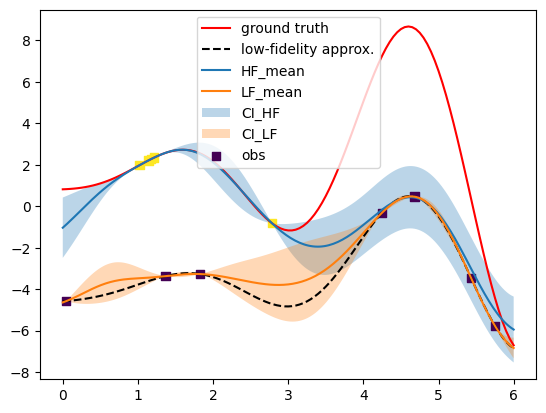

(402,)


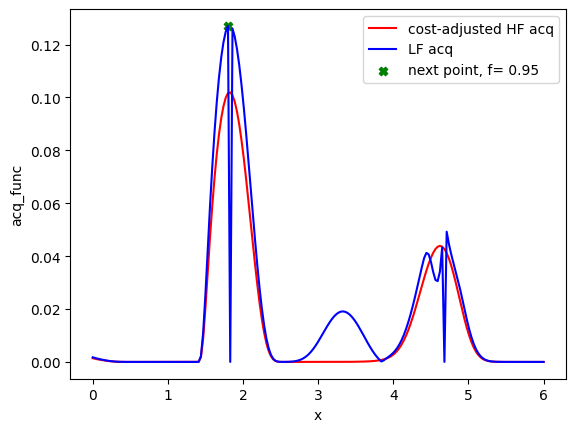

[239 240 235 156  61  60]
User interraction for policy change
Do you want to update current policy? y- Yes or press ENTER- No
What policies you want to change? Options: 1-parameter space, 2-surrogate model, 3-acq. func., 4-convergence
choices made:  [3, 4]
Provide new cost ratio between high and low fidelities
Provide new number of total iterations.
Step:13


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:04<00:00, 230.27it/s, 7 steps of size 3.97e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      2.80      0.58      2.75      1.91      3.80    342.72      1.00
  k_length      0.17      0.02      0.17      0.13      0.20    115.52      1.00
   k_scale      9.91      1.81      9.77      6.91     12.81    321.49      1.00
     noise      1.63      2.32      0.97      0.08      3.50    296.09      1.00



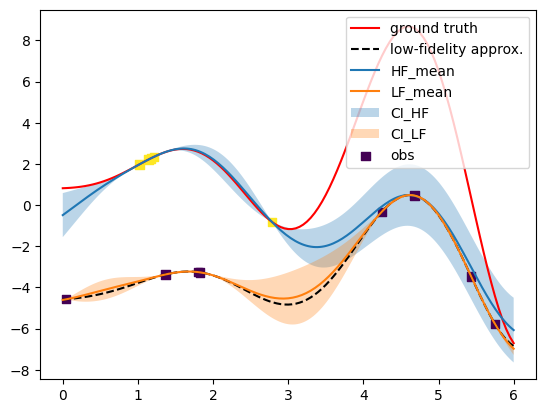

(402,)


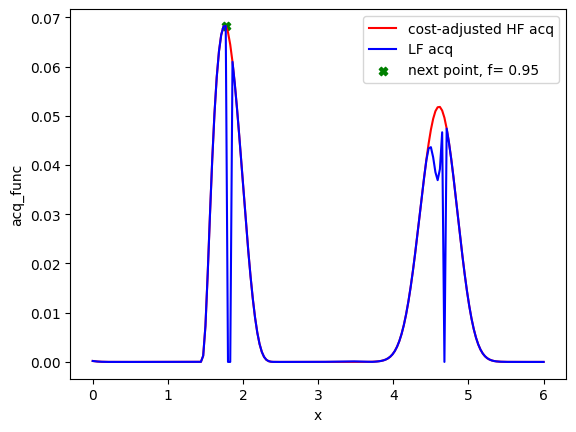

[239 240 235 156  61  60  59]
Step:14


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:04<00:00, 237.06it/s, 7 steps of size 4.62e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      2.81      0.57      2.73      1.87      3.73    413.34      1.00
  k_length      0.17      0.02      0.17      0.14      0.20    193.51      1.00
   k_scale      9.91      1.73      9.81      6.89     12.36    491.69      1.00
     noise      1.62      1.94      1.00      0.07      3.53    278.55      1.00



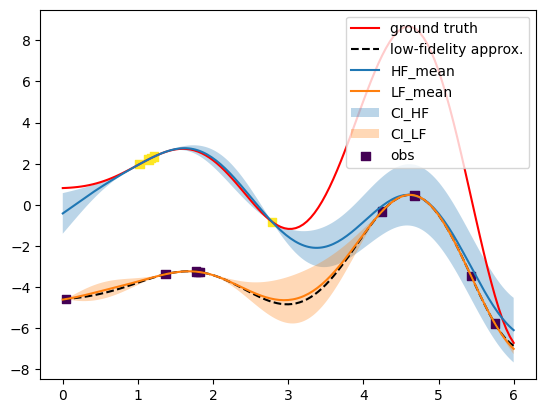

(402,)


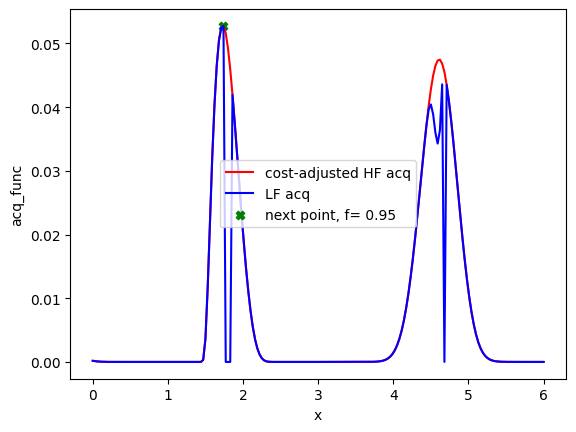

[239 240 235 156  61  60  59  58]
Step:15


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:04<00:00, 242.28it/s, 7 steps of size 5.12e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      2.78      0.55      2.71      1.82      3.59    520.55      1.00
  k_length      0.17      0.02      0.17      0.14      0.20    182.37      1.00
   k_scale      9.93      1.75      9.88      6.98     12.78    565.05      1.00
     noise      1.57      1.95      0.94      0.05      3.27    282.46      1.00



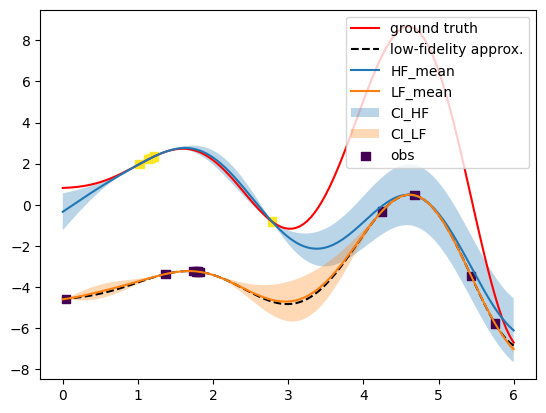

(402,)


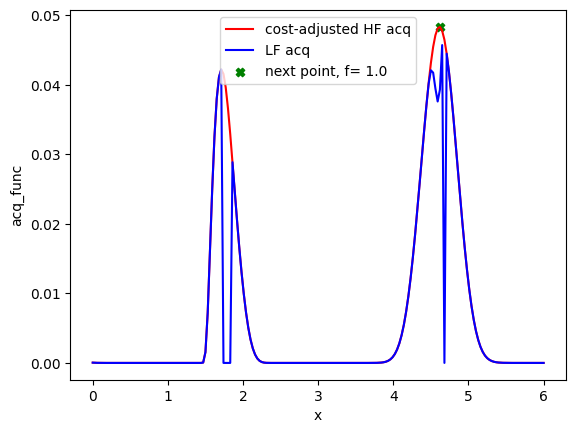

[239 240 235 156  61  60  59  58 355]
Step:16


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:04<00:00, 239.10it/s, 7 steps of size 5.34e-01. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      3.53      0.56      3.52      2.68      4.53    489.08      1.00
  k_length      0.17      0.02      0.17      0.14      0.19    279.68      1.00
   k_scale     12.04      1.76     12.06      9.31     15.05    639.23      1.00
     noise      1.78      2.45      1.05      0.04      3.81    330.59      1.00



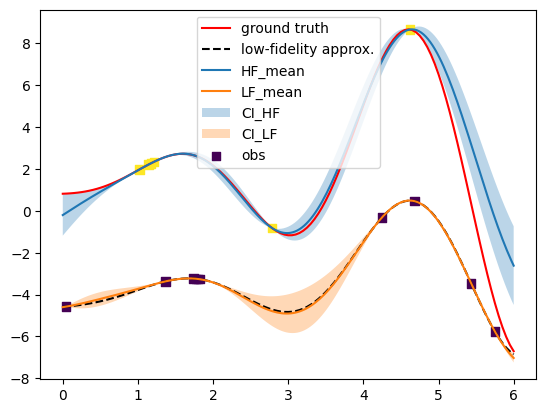

(402,)


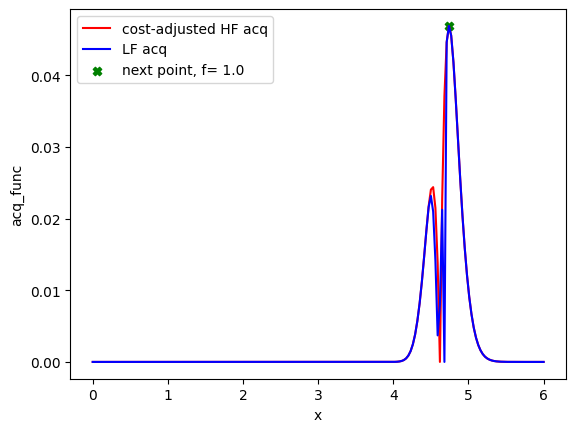

[239 240 235 156  61  60  59  58 355 359]
Step:17


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:04<00:00, 233.54it/s, 7 steps of size 6.60e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      3.53      0.58      3.50      2.62      4.54    667.94      1.00
  k_length      0.16      0.02      0.16      0.14      0.19    370.50      1.00
   k_scale     11.83      1.77     11.86      8.85     14.44    426.46      1.00
     noise      1.78      2.46      1.03      0.03      4.11    260.99      1.00



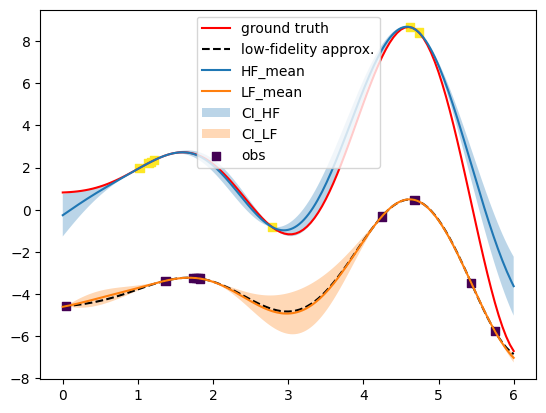

(402,)


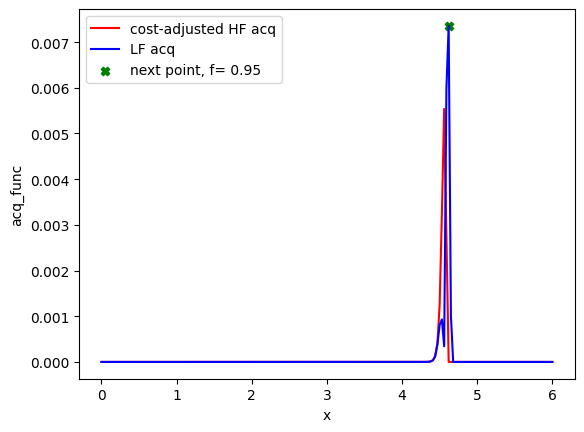

[239 240 235 156  61  60  59  58 355 359 154]
Step:18


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:04<00:00, 236.56it/s, 3 steps of size 6.85e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      3.55      0.59      3.50      2.54      4.38    532.79      1.00
  k_length      0.16      0.01      0.16      0.14      0.18    415.64      1.00
   k_scale     11.69      1.75     11.64      9.01     14.85    411.59      1.00
     noise      1.81      2.32      1.07      0.03      4.00    277.97      1.00



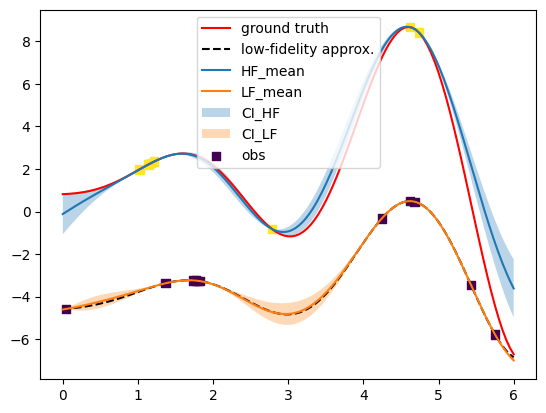

(402,)


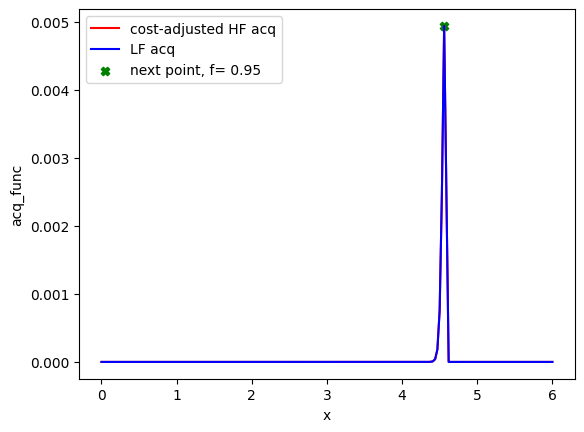

[239 240 235 156  61  60  59  58 355 359 154 152]
Step:19


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:04<00:00, 238.03it/s, 7 steps of size 5.41e-01. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      3.51      0.57      3.47      2.50      4.36    541.07      1.00
  k_length      0.16      0.01      0.16      0.15      0.18    463.69      1.00
   k_scale     11.84      1.74     11.89      8.87     14.63    459.24      1.00
     noise      1.56      2.08      0.99      0.06      3.27    428.70      1.00



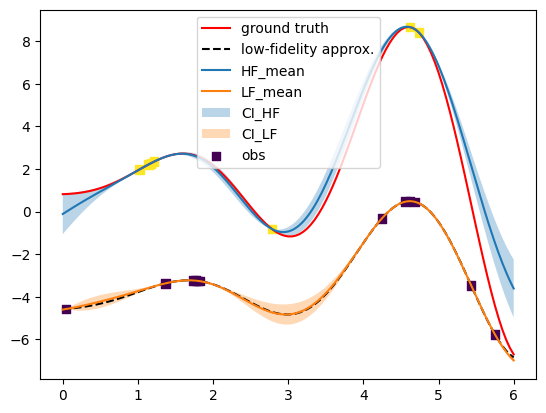

(402,)


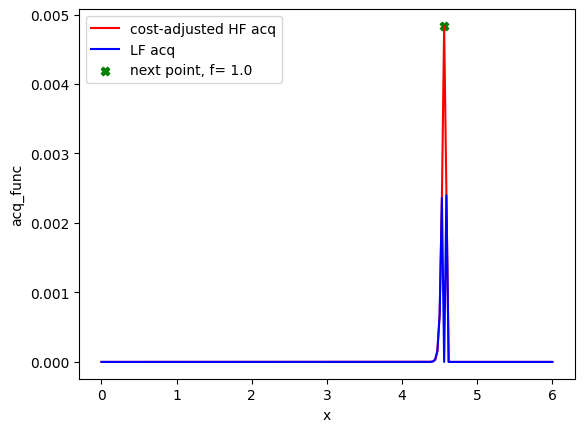

[239 240 235 156  61  60  59  58 355 359 154 152 353]
User interraction for policy change
Do you want to update current policy? y- Yes or press ENTER- No
Step:20


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:04<00:00, 235.34it/s, 7 steps of size 5.87e-01. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      3.58      0.57      3.56      2.51      4.39    565.89      1.00
  k_length      0.15      0.01      0.15      0.13      0.17    433.81      1.00
   k_scale     11.71      1.76     11.67      9.08     14.76    701.91      1.00
     noise      1.71      2.32      1.04      0.06      3.72    419.79      1.00



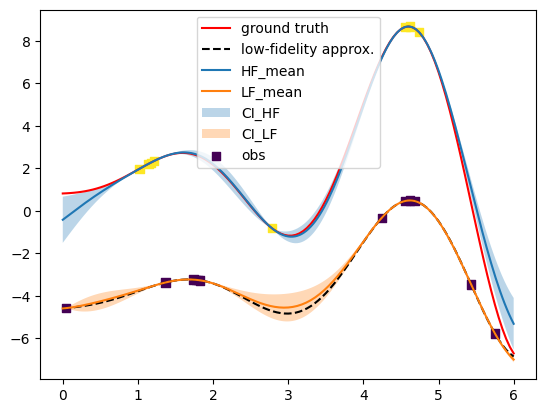

(402,)


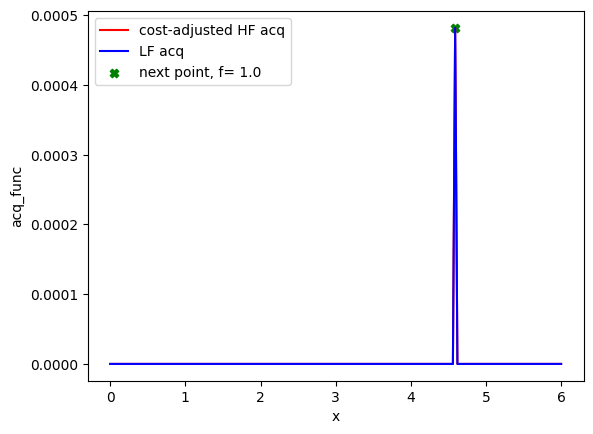

[239 240 235 156  61  60  59  58 355 359 154 152 353 354]
Step:21


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:04<00:00, 222.13it/s, 7 steps of size 6.54e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      3.57      0.57      3.53      2.54      4.39    670.37      1.00
  k_length      0.15      0.01      0.15      0.13      0.17    541.24      1.00
   k_scale     11.69      1.72     11.69      8.79     14.34    424.35      1.00
     noise      1.83      2.62      1.05      0.05      4.21    321.47      1.00



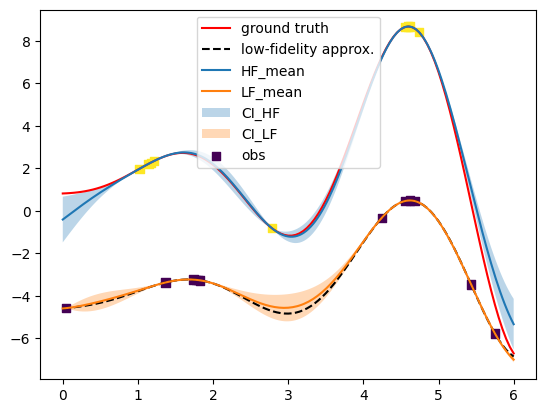

(402,)


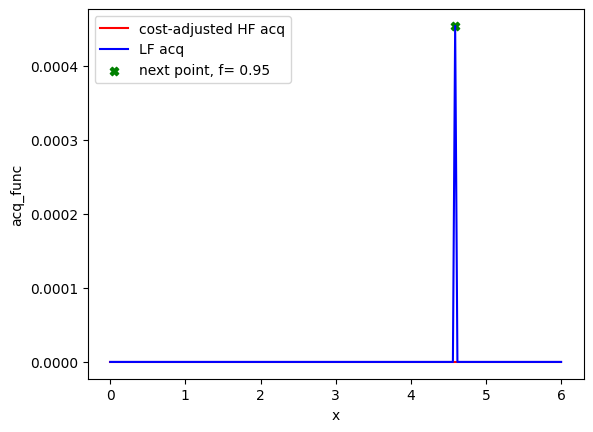

[239 240 235 156  61  60  59  58 355 359 154 152 353 354 153]
Step:22


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:04<00:00, 226.41it/s, 7 steps of size 6.35e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      3.55      0.57      3.52      2.59      4.38    430.02      1.00
  k_length      0.15      0.01      0.15      0.14      0.17    487.24      1.00
   k_scale     11.75      1.75     11.75      8.85     14.34    540.67      1.00
     noise      1.74      2.72      0.95      0.06      3.79    260.53      1.01



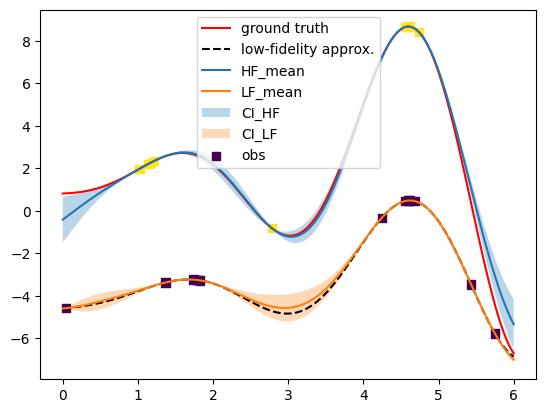

(402,)


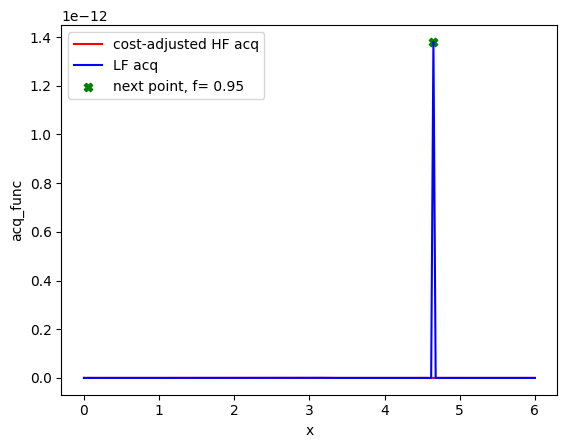

[239 240 235 156  61  60  59  58 355 359 154 152 353 354 153 155]
Step:23


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:04<00:00, 229.95it/s, 7 steps of size 6.66e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      3.57      0.56      3.53      2.69      4.52    437.31      1.00
  k_length      0.15      0.01      0.15      0.13      0.17    413.16      1.00
   k_scale     11.76      1.69     11.71      8.96     14.36    418.23      1.00
     noise      1.81      2.64      1.01      0.03      4.17    300.67      1.00



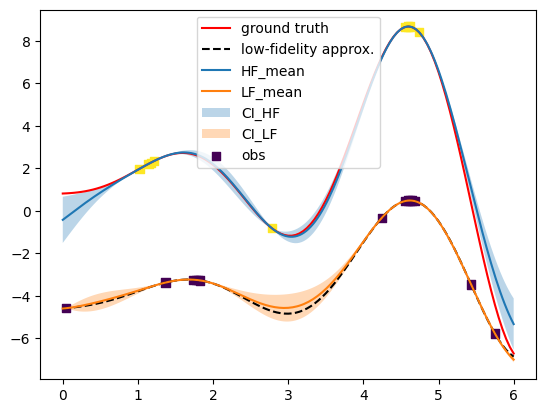

(402,)


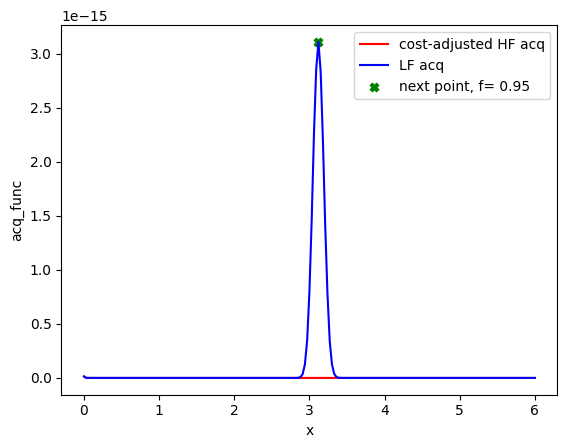

[239 240 235 156  61  60  59  58 355 359 154 152 353 354 153 155 104]
Step:24


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:04<00:00, 222.14it/s, 7 steps of size 6.66e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      3.55      0.56      3.52      2.72      4.58    636.32      1.00
  k_length      0.16      0.01      0.16      0.14      0.17    451.01      1.00
   k_scale     11.78      1.83     11.69      8.70     14.61    413.06      1.00
     noise      1.72      2.31      1.03      0.05      3.72    403.86      1.00



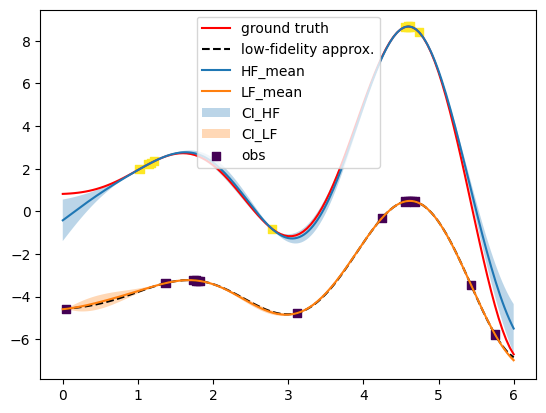

(402,)


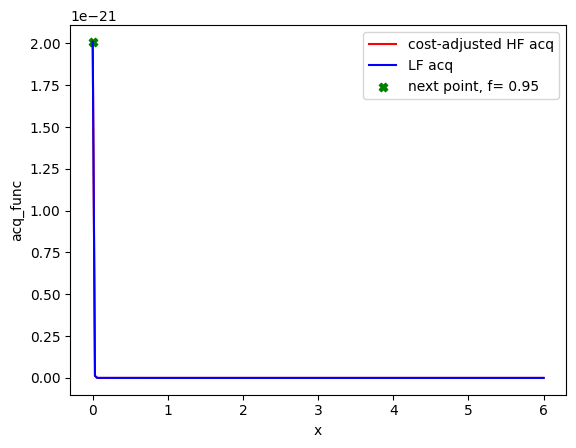

[239 240 235 156  61  60  59  58 355 359 154 152 353 354 153 155 104   0]
User interraction for policy change
Do you want to update current policy? y- Yes or press ENTER- No
Step:25


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:04<00:00, 223.42it/s, 7 steps of size 6.02e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      3.57      0.57      3.54      2.56      4.40    520.04      1.00
  k_length      0.16      0.01      0.16      0.14      0.17    434.71      1.00
   k_scale     11.78      1.76     11.80      8.98     14.58    437.86      1.00
     noise      1.66      2.18      0.97      0.06      3.80    265.49      1.00



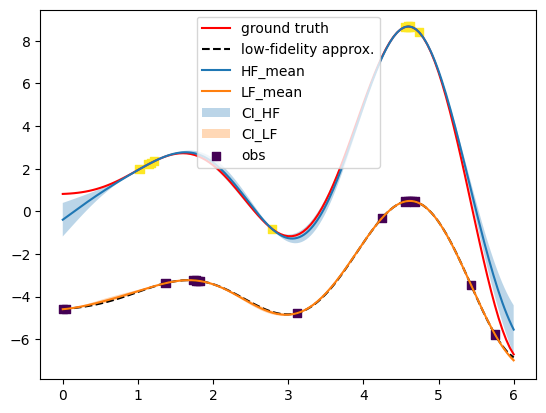

(402,)


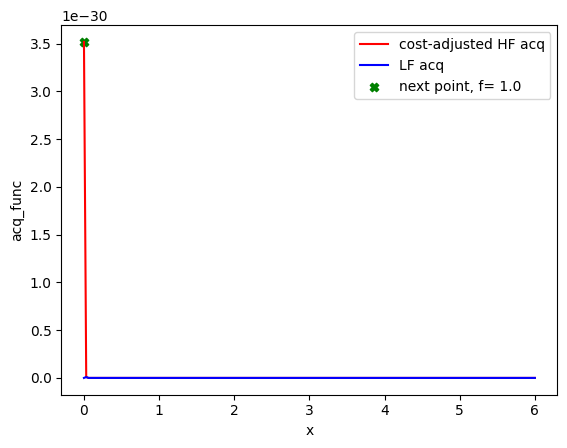

[239 240 235 156  61  60  59  58 355 359 154 152 353 354 153 155 104   0
 201]


In [ ]:
N = 15
cost_ratio = 2
imodel = 2 # Structured GP
f = np.array([1.0, 2.0])
hist_policy={}
# Get random number generator keys for training and prediction
rng_key, rng_key_predict = gpax.utils.get_keys()
idx = []
p = 0
j = 1
i = 1
while (i < N+1):
    print("Step:"+str(i))

    # Multi-fidelity structured GP
    if imodel == 2:
        gp_model = gpax.ExactGP(1, kernel= fidelity_kernel, kernel_prior = fidelity_kernel_prior, mean_fn=mean_func2, mean_fn_prior=mf2_priors)
        # Run MCMC to obtain posterior samples
        gp_model.fit(rng_key, train_x_full_norm, train_y, num_chains=1)
    else:
        gp_model = gpax.ExactGP(1, kernel= fidelity_kernel, kernel_prior = fidelity_kernel_prior)
        # Run MCMC to obtain posterior samples
        gp_model.fit(rng_key, train_x_full_norm, train_y, num_warmup=500, num_samples=500, num_chains=1)


    if ((i == 1) or ((i % 1) == 0)): # Check predictions
        ys = ys[xs<=np.max(X_test[:,0])]
        approx_ys = approx_ys[xs<=np.max(X_test[:,0])]
        xs = xs[xs<=np.max(X_test[:,0])]

        y_pred, y_sampled = gp_model.predict(rng_key_predict, X_test_norm[X_test_lf.shape[0]:, :], n=200)
        y_pred_lf, y_sampled_lf = gp_model.predict(rng_key_predict, X_test_norm[0:X_test_lf.shape[0], :], n=200)

        plt.plot(xs, ys, label="ground truth", c="r")
        plt.plot(xs, approx_ys, "k--", label="low-fidelity approx.")
        pred_lower = y_pred - y_sampled.std(axis=(0,1))
        pred_upper = y_pred + y_sampled.std(axis=(0,1))
        pred_lower_lf = y_pred_lf - y_sampled_lf.std(axis=(0,1))
        pred_upper_lf = y_pred_lf + y_sampled_lf.std(axis=(0,1))
        plt.plot(X_test[X_test_lf.shape[0]:, 0], y_pred, label="HF_mean")
        plt.plot(X_test[X_test_lf.shape[0]:, 0], y_pred_lf, label="LF_mean")
        plt.fill_between(
            X_test[X_test_lf.shape[0]:, 0].flatten(),
            pred_lower,
            pred_upper,
            alpha=0.3,
            label="CI_HF",
        )

        plt.fill_between(
            X_test[X_test_lf.shape[0]:, 0].flatten(),
            pred_lower_lf,
            pred_upper_lf,
            alpha=0.3,
            label="CI_LF",
        )

        plt.scatter(train_x_full[:, 0], train_y, c=train_x_full[:, 1], cmap="viridis", marker="s", label="obs")

        plt.legend(loc="best")
        plt.show()
    # Compute the MF acq function - EI based
    test_data = [X_test, X_test_norm]
    acq, next_point_idx, next_point_val  = fidelity_acqfun(gp_model, test_data, f, cost_ratio, rng_key_predict, idx, isnorm=True)
    idx = np.hstack((idx, next_point_idx))
    if len(idx) == 1:
        idx = int(idx)
        print(idx)
    else:
        idx = idx
        print(idx)

    # acq = gpax.acquisition.EI(rng_key_predict, gp_model, X_test, maximize=True, noiseless=True)
    # acq = gpax.acquisition.UCB(rng_key_predict, gp_model, X_test, beta=4, maximize=True, noiseless=True)
    if next_point_val == 0:
        print("Model sufficiently learned")
        #Check for the need of policy change
        print("Do you want to update current policy? y- Yes or press ENTER- No")
        ip = str(input("Answer: "))
        if (ip == 'Y' or ip == 'y'):
            print("User interraction for policy change")
            X_test, X_test_norm, imodel, cost_ratio, N, idx = ipolicy(X_test, X_test_norm, imodel, cost_ratio, N, i, idx)
        else:
            break
    else:
        next_point = X_test[next_point_idx]
        next_point_norm = X_test_norm[next_point_idx]
        train_x_full = np.vstack((train_x_full, next_point))
        train_x_full_norm = np.vstack((train_x_full_norm, next_point_norm))
        #print(next_point_idx, next_point, next_point_norm, train_x_full, train_x_full_norm)

        train_y = evaluate_all_functions(train_x_full)

    #Check for the need of policy change
    t_y1 = train_y[-5]
    t_y2 = np.max(train_y[-4:])
    if (j>=5) & (t_y1 >= t_y2):
      #Storing training data of earlier policies
        j = 0
        hist_policy[p] = {'train_x': train_x_full, 'train_x_norm': train_x_full_norm, 'train_y': train_y, 'cost_ratio': cost_ratio}
        p = p + 1
        print("User interraction for policy change")
        train_x_full, train_x_full_norm, train_y, X_test, X_test_norm, imodel, cost_ratio, N, idx = ipolicy(train_x_full, train_x_full_norm, train_y, X_test, X_test_norm, imodel, cost_ratio, N, i, idx)
    j = j + 1
    i = i + 1
    #X_test = np.concatenate([X_test[:next_point_idx], X_test[next_point_idx+1:]])
    #print(X_test.shape)

In [ ]:
train_x_full, hist_policy[0]['train_x']

(array([[5.43404942, 0.95      ],
        [2.78369385, 1.        ],
        [4.24517591, 0.95      ],
        [0.04718856, 0.95      ],
        [1.21569121, 1.        ],
        [1.3670659 , 0.95      ],
        [5.75093329, 0.95      ],
        [1.14      , 1.        ],
        [1.17      , 1.        ],
        [1.02      , 1.        ],
        [4.68      , 0.95      ],
        [1.83      , 0.95      ],
        [1.8       , 0.95      ],
        [1.77      , 0.95      ],
        [1.74      , 0.95      ],
        [4.62      , 1.        ],
        [4.74      , 1.        ],
        [4.62      , 0.95      ],
        [4.56      , 0.95      ],
        [4.56      , 1.        ],
        [4.59      , 1.        ],
        [4.59      , 0.95      ],
        [4.65      , 0.95      ],
        [3.12      , 0.95      ],
        [0.        , 0.95      ],
        [0.        , 1.        ]]),
 array([[ 5.43404942,  0.95      ],
        [ 2.78369385,  1.        ],
        [ 4.24517591,  0.95      ],
      